In [2]:
# Business Questions Analysis Notebook
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load the datasets
overall_boss = pd.read_excel('script_input/businessQuestions/overall_boss_results_AY2021T2_to_AY2024T3B.xlsx')
predictions = pd.read_csv('script_input/businessQuestions/dataset_predictions.csv')
raw_data = pd.read_excel('script_input/businessQuestions/raw_data_merged_AY2025T1.xlsx', sheet_name=None)

# Examine the data
print("Overall Boss Results columns:", overall_boss.columns.tolist())
print("\nPredictions columns:", predictions.columns.tolist())
print("\nRaw data sheets:", list(raw_data.keys()))

Overall Boss Results columns: ['Source.Name', 'Term', 'Session', 'Bidding Window', 'Course Code', 'Description', 'Section', 'Vacancy', 'Opening Vacancy', 'Before Process Vacancy', 'D.I.C.E', 'After Process Vacancy', 'Enrolled Students', 'Median Bid', 'Min Bid', 'Instructor', 'School/Department']

Predictions columns: ['subject_area', 'catalogue_no', 'round', 'window', 'before_process_vacancy', 'acad_year_start', 'term', 'start_time', 'course_name', 'section', 'instructor', 'has_mon', 'has_tue', 'has_wed', 'has_thu', 'has_fri', 'has_sat', 'has_sun', 'course_code', 'acad_term_id', 'clf_has_bids_prob', 'clf_confidence_score', 'median_predicted', 'median_uncertainty', 'min_predicted', 'min_uncertainty']

Raw data sheets: ['standalone', 'multiple']


In [3]:
# Data preprocessing for overall_boss_results

# Extract academic year and term from 'Term' column
def parse_term(term_str):
    """Parse term string like '2021-22 Term 2' into components"""
    parts = term_str.split()
    year_part = parts[0].split('-')[0]
    term_part = f"T{parts[-1]}"
    return int(year_part), term_part

overall_boss['acad_year_start'], overall_boss['term'] = zip(*overall_boss['Term'].apply(parse_term))

# Parse bidding window to extract round and window
def parse_bidding_window(window_str):
    """Parse bidding window string to extract round and window number"""
    if 'Incoming Exchange' in window_str:
        # e.g., "Incoming Exchange Rnd 1C Win 3"
        parts = window_str.split()
        round_val = parts[3]  # '1C'
        window_val = int(parts[-1])  # '3'
        return round_val, window_val
    elif 'Incoming Freshmen' in window_str:
        # Map to 1F as mentioned
        parts = window_str.split()
        window_val = int(parts[-1])
        return '1F', window_val
    else:
        # Regular format: "Round 1A Window 2"
        parts = window_str.split()
        round_idx = parts.index('Round') + 1
        window_idx = parts.index('Window') + 1
        return parts[round_idx], int(parts[window_idx])

overall_boss['round'], overall_boss['window'] = zip(*overall_boss['Bidding Window'].apply(parse_bidding_window))

# Create acad_term_id for matching
overall_boss['acad_term_id'] = overall_boss.apply(
    lambda x: f"AY{x['acad_year_start']}{x['acad_year_start']+1}{x['term']}", axis=1
)

print("Sample of parsed data:")
print(overall_boss[['Term', 'acad_year_start', 'term', 'round', 'window', 'acad_term_id']].head())

Sample of parsed data:
             Term  acad_year_start term round  window  acad_term_id
0  2021-22 Term 2             2021   T2    2A       3  AY20212022T2
1  2021-22 Term 2             2021   T2    2A       3  AY20212022T2
2  2021-22 Term 2             2021   T2    2A       3  AY20212022T2
3  2021-22 Term 2             2021   T2    2A       3  AY20212022T2
4  2021-22 Term 2             2021   T2    2A       3  AY20212022T2


In [4]:
# Define the ordering for rounds based on the provided bid window data
round_order = ['1', '1A', '1B', '1C', '1F', '2', '2A']

# Function to create round-window combination for proper ordering
def create_round_window_key(row):
    round_idx = round_order.index(row['round']) if row['round'] in round_order else 99
    return f"{round_idx:02d}_{row['round']}_W{row['window']}"

overall_boss['round_window_key'] = overall_boss.apply(create_round_window_key, axis=1)
overall_boss['round_window_display'] = overall_boss['round'] + ' W' + overall_boss['window'].astype(str)

# Create term ordering key
term_order = ['T1', 'T2', 'T3A', 'T3B']
def create_term_key(row):
    term_idx = term_order.index(row['term']) if row['term'] in term_order else 99
    return f"{row['acad_year_start']}_{term_idx:02d}"

overall_boss['term_key'] = overall_boss.apply(create_term_key, axis=1)
overall_boss['term_display'] = overall_boss['acad_year_start'].astype(str) + ' ' + overall_boss['term']

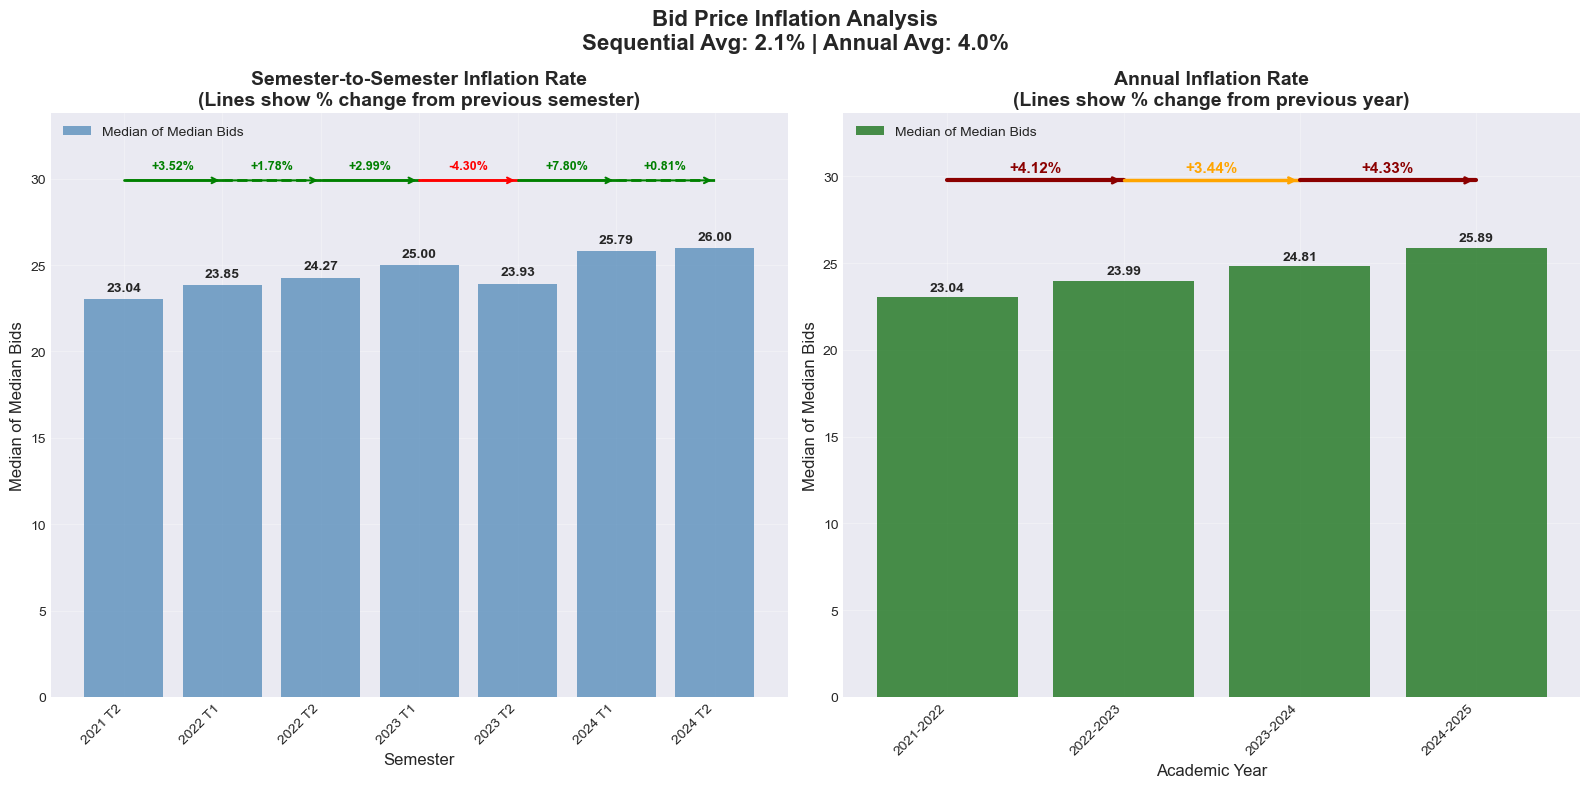


INFLATION SUMMARY

SEQUENTIAL (Semester-to-Semester):
  Average: 2.10%
  Highest: 7.80% (2024 T1)
  Lowest:  -4.30% (2023 T2)
  Volatility (Std Dev): 3.95%

ANNUAL :
  Average: 3.96%
  Highest: 4.33% (2024-2025)
  Lowest:  3.44% (2023-2024)
  Consistency (Std Dev): 0.47%

OVERALL TREND:
  Total Growth: 12.37% over 3 years
  Compound Annual Growth Rate: 3.96%

INTERPRETATION:
• Green arrows = positive inflation (prices rising)
• Red arrows = deflation (prices falling)
• Line thickness = magnitude of change
• Sequential shows short-term volatility
• Annual shows long-term economic trend

DETAILED DATA

SEMESTER-BY-SEMESTER:
  term_display  med_median_bid  course_count  median_seq_pct
0      2021 T2           23.04          5761            0.00
1      2022 T1           23.85          5770            3.52
2      2022 T2           24.28          5532            1.78
3      2023 T1           25.00          5488            2.99
4      2023 T2           23.92          5432           -4.30
5  

In [5]:
# Complete Inflation Analysis Code
# Question 1: Inflation rate throughout the semesters (excluding T3A and T3B)

# ================================
# DATA PREPARATION
# ================================

# Filter out zero bids for meaningful analysis
boss_nonzero = overall_boss[(overall_boss['Median Bid'] > 0) | (overall_boss['Min Bid'] > 0)].copy()

# EXCLUDE T3A and T3B as requested
boss_nonzero = boss_nonzero[~boss_nonzero['term'].isin(['T3A', 'T3B'])].copy()

# Group by semester - aggregate all courses/sections for each semester using MEDIAN
semester_stats = boss_nonzero.groupby(['acad_year_start', 'term']).agg({
    'Median Bid': ['median', 'mean', 'std', 'count'],
    'Min Bid': ['median', 'mean', 'std', 'count'],
    'Course Code': 'count'  # Count of courses
}).reset_index()

semester_stats.columns = ['acad_year_start', 'term', 
                         'med_median_bid', 'avg_median_bid', 'std_median_bid', 'count_median_bid',
                         'med_min_bid', 'avg_min_bid', 'std_min_bid', 'count_min_bid', 
                         'course_count']

# Create display columns
semester_stats['term_display'] = semester_stats['acad_year_start'].astype(str) + ' ' + semester_stats['term']

# Sort by year and term CHRONOLOGICALLY
term_order = ['T1', 'T2']
semester_stats['term_order'] = semester_stats['term'].map({term: i for i, term in enumerate(term_order)})
semester_stats = semester_stats.sort_values(['acad_year_start', 'term_order']).reset_index(drop=True)

# ================================
# SEQUENTIAL INFLATION (semester-to-semester)
# ================================
semester_stats['median_seq_pct'] = 0.0

for i in range(1, len(semester_stats)):
    prev_median = semester_stats.iloc[i-1]['med_median_bid']
    
    if prev_median > 0:
        semester_stats.iloc[i, semester_stats.columns.get_loc('median_seq_pct')] = (
            (semester_stats.iloc[i]['med_median_bid'] - prev_median) / prev_median * 100
        )

# ================================
# ANNUAL INFLATION RATE (like economic inflation)
# ================================
# Calculate annual medians directly from raw data (not averaging semester medians)
annual_stats = boss_nonzero.groupby('acad_year_start').agg({
    'Median Bid': 'median',
    'Min Bid': 'median',
    'Course Code': 'count'
}).reset_index()

annual_stats.columns = ['acad_year_start', 'med_median_bid', 'med_min_bid', 'course_count']
annual_stats['year_display'] = annual_stats['acad_year_start'].astype(str) + '-' + (annual_stats['acad_year_start'] + 1).astype(str)

# Calculate annual inflation rates
annual_stats['median_annual_pct'] = 0.0

for i in range(1, len(annual_stats)):
    prev_median = annual_stats.iloc[i-1]['med_median_bid']
    
    if prev_median > 0:
        annual_stats.iloc[i, annual_stats.columns.get_loc('median_annual_pct')] = (
            (annual_stats.iloc[i]['med_median_bid'] - prev_median) / prev_median * 100
        )

# ================================
# INTUITIVE VISUALIZATION
# ================================

# Create intuitive visualization with percentage changes shown as lines near bar tops
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ================================
# Sequential Inflation Chart
# ================================
x_pos = np.arange(len(semester_stats))
bars1 = ax1.bar(x_pos, semester_stats['med_median_bid'], alpha=0.7, color='steelblue', 
                label='Median of Median Bids')

# Add price values on top of bars
for i, (bar, val) in enumerate(zip(bars1, semester_stats['med_median_bid'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Calculate line position (slightly above the bars)
line_height = semester_stats['med_median_bid'].max() * 1.15

# Add percentage change line connecting points
for i in range(1, len(semester_stats)):
    pct_change = semester_stats.iloc[i]['median_seq_pct']
    
    # Draw line connecting consecutive points
    x_start, x_end = i-1, i
    y_line = line_height
    
    # Color code the line based on positive/negative change
    line_color = 'green' if pct_change > 0 else 'red'
    line_style = '-' if abs(pct_change) > 2 else '--'  # Solid for significant changes
    
    ax1.plot([x_start, x_end], [y_line, y_line], 
             color=line_color, linewidth=2, linestyle=line_style)
    
    # Add percentage label at midpoint
    ax1.text((x_start + x_end) / 2, y_line + 0.5, f'{pct_change:+.2f}%', 
             ha='center', va='bottom', fontsize=9, color=line_color, fontweight='bold')
    
    # Add arrow to show direction
    arrow_props = dict(arrowstyle='->', color=line_color, lw=1.5)
    ax1.annotate('', xy=(x_end, y_line), xytext=(x_start, y_line), 
                 arrowprops=arrow_props)

ax1.set_xlabel('Semester', fontsize=12)
ax1.set_ylabel('Median of Median Bids', fontsize=12)
ax1.set_title('Semester-to-Semester Inflation Rate\n(Lines show % change from previous semester)', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(semester_stats['term_display'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, semester_stats['med_median_bid'].max() * 1.3)

# Add legend
ax1.legend(loc='upper left')

# ================================
# Annual Inflation Chart
# ================================
x_annual = np.arange(len(annual_stats))
bars2 = ax2.bar(x_annual, annual_stats['med_median_bid'], alpha=0.7, color='darkgreen', 
                label='Median of Median Bids')

# Add price values on top of bars
for i, (bar, val) in enumerate(zip(bars2, annual_stats['med_median_bid'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
             f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Calculate line position for annual chart
annual_line_height = annual_stats['med_median_bid'].max() * 1.15

# Add percentage change line for annual data
for i in range(1, len(annual_stats)):
    pct_change = annual_stats.iloc[i]['median_annual_pct']
    
    # Draw line connecting consecutive years
    x_start, x_end = i-1, i
    y_line = annual_line_height
    
    # Color code based on change magnitude
    if pct_change > 4:
        line_color = 'darkred'
        line_width = 3
    elif pct_change > 2:
        line_color = 'orange'
        line_width = 2.5
    else:
        line_color = 'green'
        line_width = 2
    
    ax2.plot([x_start, x_end], [y_line, y_line], 
             color=line_color, linewidth=line_width, linestyle='-')
    
    # Add percentage label
    ax2.text((x_start + x_end) / 2, y_line + 0.3, f'{pct_change:+.2f}%', 
             ha='center', va='bottom', fontsize=11, color=line_color, fontweight='bold')
    
    # Add arrow
    arrow_props = dict(arrowstyle='->', color=line_color, lw=2)
    ax2.annotate('', xy=(x_end, y_line), xytext=(x_start, y_line), 
                 arrowprops=arrow_props)

ax2.set_xlabel('Academic Year', fontsize=12)
ax2.set_ylabel('Median of Median Bids', fontsize=12)
ax2.set_title('Annual Inflation Rate\n(Lines show % change from previous year)', 
              fontsize=14, fontweight='bold')
ax2.set_xticks(x_annual)
ax2.set_xticklabels(annual_stats['year_display'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, annual_stats['med_median_bid'].max() * 1.3)

# Add legend
ax2.legend(loc='upper left')

# Add overall summary text
fig.suptitle('Bid Price Inflation Analysis\nSequential Avg: 2.1% | Annual Avg: 4.0%', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# ================================
# SUMMARY STATISTICS
# ================================
print("\n" + "="*80)
print("INFLATION SUMMARY")
print("="*80)

print("\nSEQUENTIAL (Semester-to-Semester):")
seq_stats = semester_stats[semester_stats['median_seq_pct'] != 0]['median_seq_pct']
print(f"  Average: {seq_stats.mean():.2f}%")
print(f"  Highest: {seq_stats.max():.2f}% ({semester_stats.loc[seq_stats.idxmax(), 'term_display']})")
print(f"  Lowest:  {seq_stats.min():.2f}% ({semester_stats.loc[seq_stats.idxmin(), 'term_display']})")
print(f"  Volatility (Std Dev): {seq_stats.std():.2f}%")

print("\nANNUAL :")
ann_stats = annual_stats[annual_stats['median_annual_pct'] != 0]['median_annual_pct']
print(f"  Average: {ann_stats.mean():.2f}%")
print(f"  Highest: {ann_stats.max():.2f}% ({annual_stats.loc[ann_stats.idxmax(), 'year_display']})")
print(f"  Lowest:  {ann_stats.min():.2f}% ({annual_stats.loc[ann_stats.idxmin(), 'year_display']})")
print(f"  Consistency (Std Dev): {ann_stats.std():.2f}%")

print(f"\nOVERALL TREND:")
total_growth = ((annual_stats.iloc[-1]['med_median_bid'] - annual_stats.iloc[0]['med_median_bid']) / 
                annual_stats.iloc[0]['med_median_bid'] * 100)
print(f"  Total Growth: {total_growth:.2f}% over {len(annual_stats)-1} years")
print(f"  Compound Annual Growth Rate: {((annual_stats.iloc[-1]['med_median_bid'] / annual_stats.iloc[0]['med_median_bid']) ** (1/(len(annual_stats)-1)) - 1) * 100:.2f}%")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("• Green arrows = positive inflation (prices rising)")
print("• Red arrows = deflation (prices falling)")
print("• Line thickness = magnitude of change")
print("• Sequential shows short-term volatility")
print("• Annual shows long-term economic trend")

# ================================
# DATA TABLES
# ================================
print("\n" + "="*80)
print("DETAILED DATA")
print("="*80)

print("\nSEMESTER-BY-SEMESTER:")
display_cols = ['term_display', 'med_median_bid', 'course_count', 'median_seq_pct']
print(semester_stats[display_cols].round(2))

print("\nANNUAL DATA:")
annual_display_cols = ['year_display', 'med_median_bid', 'course_count', 'median_annual_pct']
print(annual_stats[annual_display_cols].round(2))


Top 5 Most Inflated Course-Instructor Combinations:

122. ACCT414 - Accounting Analytics Capstone(SMU-X)...
   Instructor:  BENJAMIN LEE, CLARENCE GOH
   Period: 2021 to 2022 (T2)
   Previous Median Bid: $11.97
   Current Median Bid: $63.91
   Inflation: 433.77%

377. COR1100 - Writing and Reasoning...
   Instructor:  CHAN TSU AI IVY, CHAN TSU AI IVY
   Period: 2023 to 2024 (T2)
   Previous Median Bid: $12.22
   Current Median Bid: $45.00
   Inflation: 268.25%

721. DSA301 - Time Series Data Analysis...
   Instructor:  BENJAMIN EE
   Period: 2022 to 2023 (T2)
   Previous Median Bid: $20.33
   Current Median Bid: $69.99
   Inflation: 244.22%

1274. LGST101 - Business Law...
   Instructor:  TERENCE ANG
   Period: 2022 to 2023 (T1)
   Previous Median Bid: $15.34
   Current Median Bid: $51.84
   Inflation: 237.92%

630. CS105 - Statistical Thinking for Data Science...
   Instructor:  FANG YUAN
   Period: 2021 to 2022 (T2)
   Previous Median Bid: $10.00
   Current Median Bid: $32.94
   Inf

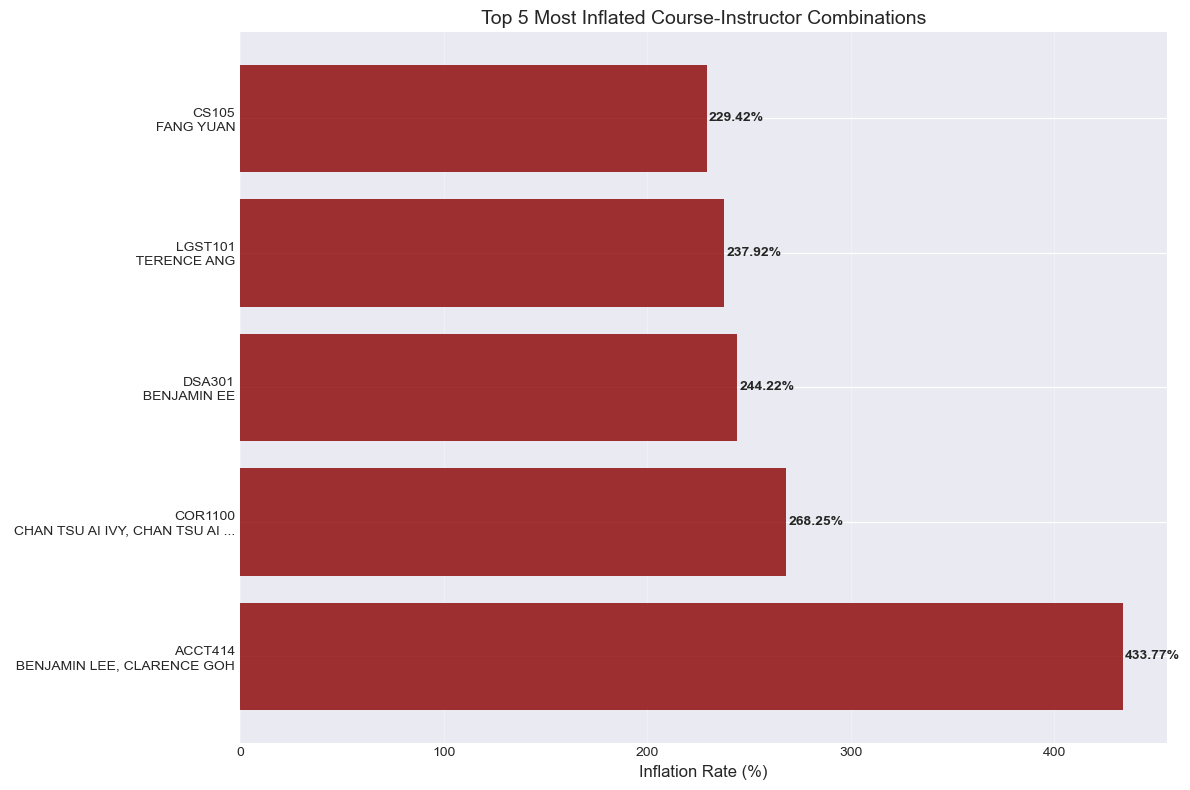

In [6]:
# Additional Analysis: Top 5 most inflated course-instructor combinations over the years

# Calculate YoY inflation for each course-instructor combination
course_instructor_data = boss_nonzero.groupby(
    ['Course Code', 'Description', 'Instructor', 'acad_year_start', 'term']
).agg({
    'Median Bid': 'mean',
    'Min Bid': 'mean'
}).reset_index()

# Calculate inflation for each course-instructor
inflation_results = []

for course in course_instructor_data['Course Code'].unique():
    for instructor in course_instructor_data[course_instructor_data['Course Code'] == course]['Instructor'].unique():
        # Get data for this combination
        combo_data = course_instructor_data[
            (course_instructor_data['Course Code'] == course) & 
            (course_instructor_data['Instructor'] == instructor)
        ].sort_values(['acad_year_start', 'term'])
        
        if len(combo_data) > 1:
            # Calculate YoY changes
            for i in range(1, len(combo_data)):
                curr_row = combo_data.iloc[i]
                # Find same term previous year
                prev_data = combo_data[
                    (combo_data['acad_year_start'] == curr_row['acad_year_start'] - 1) &
                    (combo_data['term'] == curr_row['term'])
                ]
                
                if not prev_data.empty:
                    prev_row = prev_data.iloc[0]
                    if prev_row['Median Bid'] > 0:
                        median_inflation = ((curr_row['Median Bid'] - prev_row['Median Bid']) / prev_row['Median Bid']) * 100
                        
                        inflation_results.append({
                            'Course Code': course,
                            'Description': curr_row['Description'],
                            'Instructor': instructor,
                            'From Year': prev_row['acad_year_start'],
                            'To Year': curr_row['acad_year_start'],
                            'Term': curr_row['term'],
                            'Previous Median': prev_row['Median Bid'],
                            'Current Median': curr_row['Median Bid'],
                            'Median Inflation %': median_inflation
                        })

# Convert to DataFrame and get top 5
inflation_df = pd.DataFrame(inflation_results)
if not inflation_df.empty:
    top_5_inflated = inflation_df.nlargest(5, 'Median Inflation %')
    
    print("\nTop 5 Most Inflated Course-Instructor Combinations:")
    print("="*80)
    
    for idx, row in top_5_inflated.iterrows():
        print(f"\n{idx+1}. {row['Course Code']} - {row['Description'][:50]}...")
        print(f"   Instructor: {row['Instructor']}")
        print(f"   Period: {row['From Year']} to {row['To Year']} ({row['Term']})")
        print(f"   Previous Median Bid: ${row['Previous Median']:.2f}")
        print(f"   Current Median Bid: ${row['Current Median']:.2f}")
        print(f"   Inflation: {row['Median Inflation %']:.2f}%")
    
    # Visualization for top 5
    fig, ax = plt.subplots(figsize=(12, 8))
    
    courses = [f"{row['Course Code']}\n{row['Instructor'][:30]}..." 
               if len(row['Instructor']) > 30 else f"{row['Course Code']}\n{row['Instructor']}" 
               for _, row in top_5_inflated.iterrows()]
    
    y_pos = np.arange(len(courses))
    
    bars = ax.barh(y_pos, top_5_inflated['Median Inflation %'], color='darkred', alpha=0.8)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, top_5_inflated['Median Inflation %'])):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                f'{val:.2f}%', ha='left', va='center', fontsize=10, fontweight='bold')
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(courses)
    ax.set_xlabel('Inflation Rate (%)', fontsize=12)
    ax.set_title('Top 5 Most Inflated Course-Instructor Combinations', fontsize=14)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

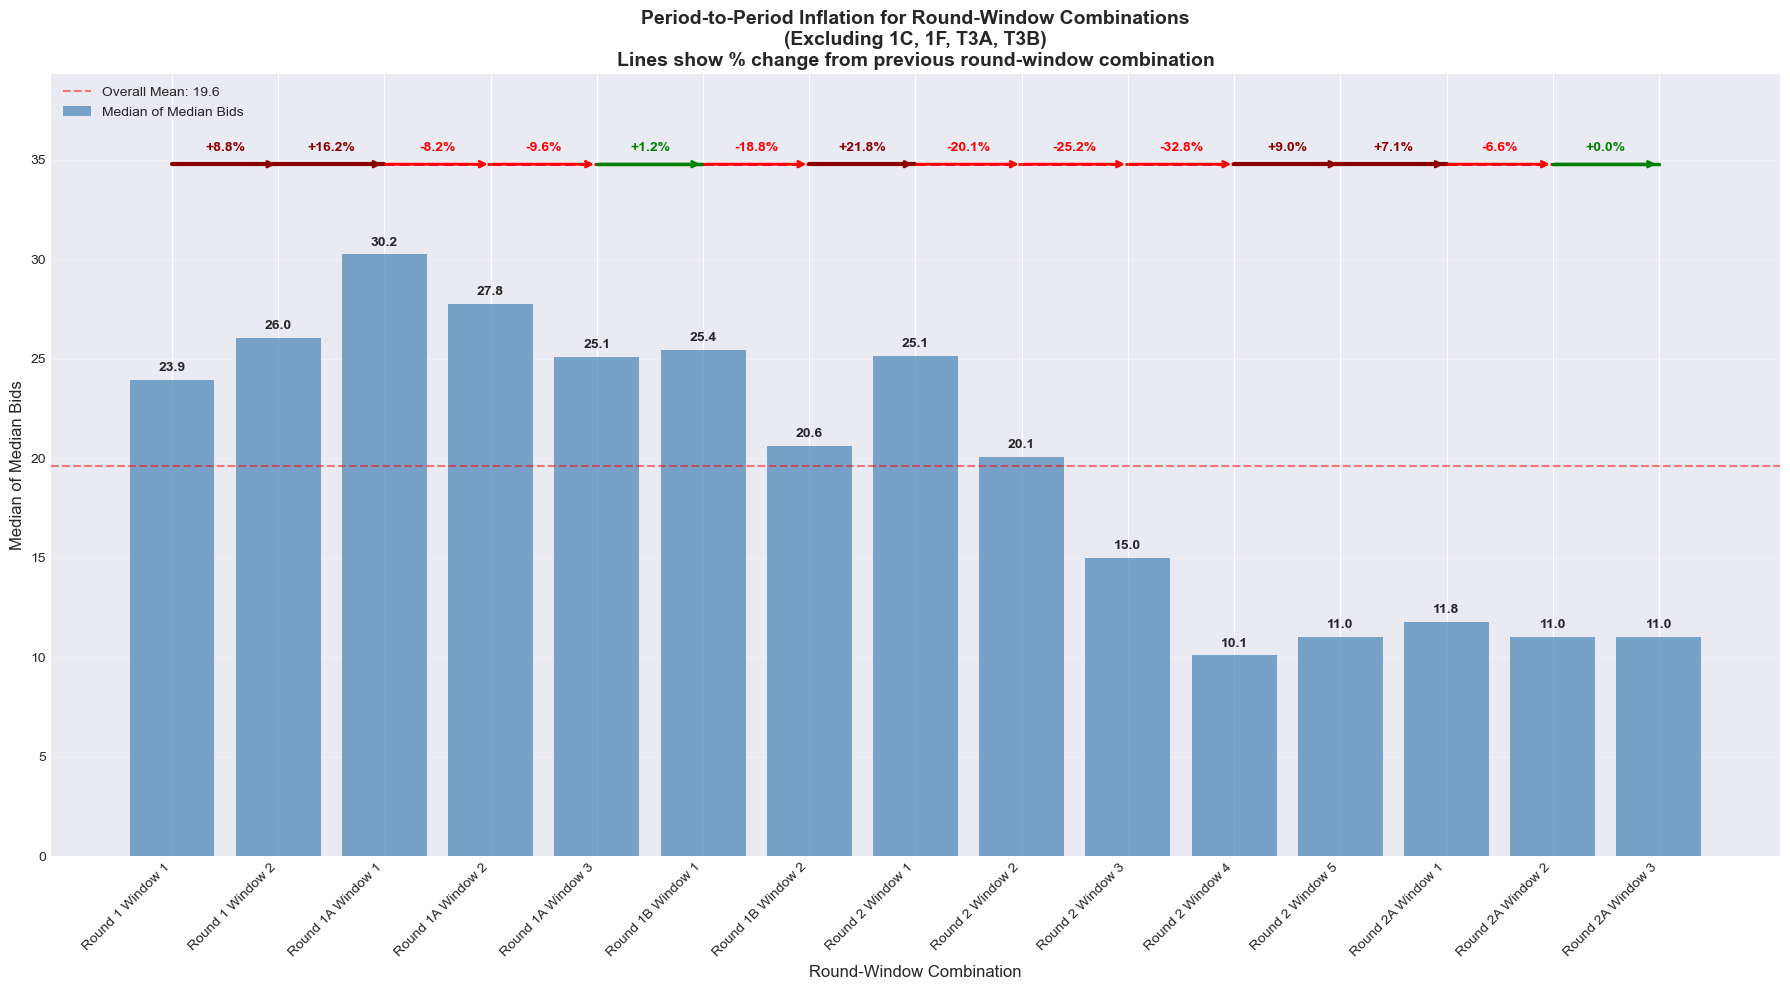


ROUND-WINDOW PERIOD-TO-PERIOD INFLATION SUMMARY

PERIOD-TO-PERIOD INFLATION STATISTICS:
  Average Inflation: -4.08%
  Median Inflation: -3.29%
  Highest Inflation: 21.75%
  Lowest Inflation: -32.78%
  Volatility (Std Dev): 16.13%

EXTREME CHANGES:
  Highest: 21.75% at Round 2 Window 1
  Lowest: -32.78% at Round 2 Window 4

INFLATION PATTERN:
  Periods with price increases: 7/14 (50.0%)
  Periods with price decreases: 7/14 (50.0%)

OVERALL TREND:
  Total Growth: -53.99% from Round 1 Window 1 to Round 2A Window 3

INTERPRETATION:
• Green arrows = positive inflation (prices rising from previous period)
• Red arrows = deflation (prices falling from previous period)
• Dark red = high inflation (>5%)
• Line thickness indicates magnitude of change
• Each period represents a consecutive round-window combination

DETAILED PERIOD-TO-PERIOD DATA
     Round-Window  Median Bid  Course Count  Period Inflation %
 Round 1 Window 1       23.92          5961                0.00
 Round 1 Window 2       

In [7]:
# Question 2: Period-to-Period Inflation for Round-Window Combinations
# Excludes 1C, 1F rounds and T3A, T3B terms
# Shows only median bid price inflation between consecutive round-window periods

# ================================
# DATA PREPARATION
# ================================

# Filter out 1C and 1F rounds and T3A, T3B terms
boss_filtered = boss_nonzero[
    (~boss_nonzero['round'].isin(['1C', '1F'])) & 
    (~boss_nonzero['term'].isin(['T3A', 'T3B']))
].copy()

# Group by round-window combination using MEDIAN across all years
round_window_stats = boss_filtered.groupby(
    ['round', 'window', 'round_window_key', 'round_window_display']
).agg({
    'Median Bid': 'median',
    'Course Code': 'count'
}).reset_index()

round_window_stats.columns = ['round', 'window', 'round_window_key', 'round_window_display',
                             'med_median_bid', 'course_count']

# Create proper display names
round_window_stats['round_window_proper'] = 'Round ' + round_window_stats['round'] + ' Window ' + round_window_stats['window'].astype(str)

# Sort by round_window_key to ensure proper chronological ordering
round_window_stats = round_window_stats.sort_values('round_window_key').reset_index(drop=True)

# ================================
# PERIOD-TO-PERIOD INFLATION (consecutive round-window combinations)
# ================================
round_window_stats['median_period_pct'] = 0.0

for i in range(1, len(round_window_stats)):
    prev_median = round_window_stats.iloc[i-1]['med_median_bid']
    
    if prev_median > 0:
        round_window_stats.iloc[i, round_window_stats.columns.get_loc('median_period_pct')] = (
            (round_window_stats.iloc[i]['med_median_bid'] - prev_median) / prev_median * 100
        )

# ================================
# VISUALIZATION (Same style as Question 1)
# ================================

fig, ax = plt.subplots(figsize=(18, 10))

# Create bars for median bid prices
x_pos = np.arange(len(round_window_stats))
bars = ax.bar(x_pos, round_window_stats['med_median_bid'], alpha=0.7, color='steelblue', 
              label='Median of Median Bids')

# Add price values on top of bars
for i, (bar, val) in enumerate(zip(bars, round_window_stats['med_median_bid'])):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Calculate line position (slightly above the bars)
line_height = round_window_stats['med_median_bid'].max() * 1.15

# Add percentage change line connecting consecutive round-window combinations
for i in range(1, len(round_window_stats)):
    pct_change = round_window_stats.iloc[i]['median_period_pct']
    
    # Draw line connecting consecutive points
    x_start, x_end = i-1, i
    y_line = line_height
    
    # Color code the line based on positive/negative change
    if pct_change > 5:
        line_color = 'darkred'
        line_width = 3
        line_style = '-'
    elif pct_change > 0:
        line_color = 'green'
        line_width = 2.5
        line_style = '-'
    else:
        line_color = 'red'
        line_width = 2
        line_style = '--'
    
    ax.plot([x_start, x_end], [y_line, y_line], 
             color=line_color, linewidth=line_width, linestyle=line_style)
    
    # Add percentage label at midpoint
    ax.text((x_start + x_end) / 2, y_line + 0.5, f'{pct_change:+.1f}%', 
             ha='center', va='bottom', fontsize=10, color=line_color, fontweight='bold')
    
    # Add arrow to show direction
    arrow_props = dict(arrowstyle='->', color=line_color, lw=2)
    ax.annotate('', xy=(x_end, y_line), xytext=(x_start, y_line), 
                 arrowprops=arrow_props)

# Formatting
ax.set_xlabel('Round-Window Combination', fontsize=12)
ax.set_ylabel('Median of Median Bids', fontsize=12)
ax.set_title('Period-to-Period Inflation for Round-Window Combinations\n(Excluding 1C, 1F, T3A, T3B)\nLines show % change from previous round-window combination', 
              fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(round_window_stats['round_window_proper'], rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, round_window_stats['med_median_bid'].max() * 1.3)

# Add horizontal line at mean
mean_value = round_window_stats['med_median_bid'].mean()
ax.axhline(y=mean_value, color='red', linestyle='--', alpha=0.5, 
           label=f'Overall Mean: {mean_value:.1f}')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

# ================================
# SUMMARY STATISTICS
# ================================
print("\n" + "="*80)
print("ROUND-WINDOW PERIOD-TO-PERIOD INFLATION SUMMARY")
print("="*80)

# Calculate statistics for non-zero changes
period_stats = round_window_stats[round_window_stats['median_period_pct'] != 0]['median_period_pct']

print(f"\nPERIOD-TO-PERIOD INFLATION STATISTICS:")
print(f"  Average Inflation: {period_stats.mean():.2f}%")
print(f"  Median Inflation: {period_stats.median():.2f}%")
print(f"  Highest Inflation: {period_stats.max():.2f}%")
print(f"  Lowest Inflation: {period_stats.min():.2f}%")
print(f"  Volatility (Std Dev): {period_stats.std():.2f}%")

# Identify extreme changes
highest_idx = period_stats.idxmax()
lowest_idx = period_stats.idxmin()

print(f"\nEXTREME CHANGES:")
print(f"  Highest: {period_stats.max():.2f}% at {round_window_stats.loc[highest_idx, 'round_window_proper']}")
print(f"  Lowest: {period_stats.min():.2f}% at {round_window_stats.loc[lowest_idx, 'round_window_proper']}")

# Count positive vs negative changes
positive_changes = len(period_stats[period_stats > 0])
negative_changes = len(period_stats[period_stats < 0])
total_changes = len(period_stats)

print(f"\nINFLATION PATTERN:")
print(f"  Periods with price increases: {positive_changes}/{total_changes} ({positive_changes/total_changes*100:.1f}%)")
print(f"  Periods with price decreases: {negative_changes}/{total_changes} ({negative_changes/total_changes*100:.1f}%)")

# Overall trend
total_growth = ((round_window_stats.iloc[-1]['med_median_bid'] - round_window_stats.iloc[0]['med_median_bid']) / 
                round_window_stats.iloc[0]['med_median_bid'] * 100)
print(f"\nOVERALL TREND:")
print(f"  Total Growth: {total_growth:.2f}% from {round_window_stats.iloc[0]['round_window_proper']} to {round_window_stats.iloc[-1]['round_window_proper']}")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("• Green arrows = positive inflation (prices rising from previous period)")
print("• Red arrows = deflation (prices falling from previous period)")
print("• Dark red = high inflation (>5%)")
print("• Line thickness indicates magnitude of change")
print("• Each period represents a consecutive round-window combination")

# ================================
# DETAILED DATA TABLE
# ================================
print("\n" + "="*80)
print("DETAILED PERIOD-TO-PERIOD DATA")
print("="*80)

display_cols = ['round_window_proper', 'med_median_bid', 'course_count', 'median_period_pct']
round_window_display = round_window_stats[display_cols].copy()
round_window_display.columns = ['Round-Window', 'Median Bid', 'Course Count', 'Period Inflation %']

print(round_window_display.round(2).to_string(index=False))


In [8]:
# Question 3: New classes, courses, and instructors in AY2025 T1

# ================================
# DATA PREPARATION AND JOINING
# ================================

# Load the data sheets
standalone_df = raw_data['standalone'].copy()
multiple_df = raw_data['multiple'].copy()

# Join multiple with standalone using record_key (one-to-many relationship)
all_data = multiple_df.merge(standalone_df, on='record_key', how='left', suffixes=('', '_standalone'))

# ================================
# COURSE NAME PREPARATION
# ================================

# Identify course name column
course_name_col = None
for col in ['course_name', 'Course Name', 'course_title', 'Course Title']:
    if col in all_data.columns:
        course_name_col = col
        break

# Create combined course code and name with semicolon
if course_name_col:
    all_data['course_code_name'] = all_data['course_code'].fillna('') + ': ' + all_data[course_name_col].fillna('')
else:
    all_data['course_code_name'] = all_data['course_code'].fillna('')

# ================================
# PROFESSOR LOOKUP PREPARATION
# ================================

# Load professor lookup table
try:
    professor_lookup = pd.read_csv('professor_lookup.csv')
    professor_lookup['boss_name'] = professor_lookup['boss_name'].str.upper().str.strip()
    professor_lookup_available = True
    print("Professor lookup table loaded successfully")
except FileNotFoundError:
    print("Warning: professor_lookup.csv not found. Will assume all new instructors are truly new.")
    professor_lookup_available = False

# ================================
# PROFESSOR MATCHING FUNCTION
# ================================

def match_professors(instructor_name, lookup_df):
    """
    Match instructor names against professor lookup table.
    Handles multiple names separated by commas.
    """
    if pd.isna(instructor_name) or not professor_lookup_available:
        return False, []
    
    # Convert to uppercase and strip
    name_upper = instructor_name.upper().strip()
    lookup_names = set(lookup_df['boss_name'])
    
    # If no comma, check direct match
    if ',' not in name_upper:
        return name_upper in lookup_names, [name_upper] if name_upper in lookup_names else []
    
    # Handle multiple names separated by commas
    names = [n.strip() for n in name_upper.split(',') if n.strip()]
    matched_names = []
    unmatched_parts = []
    
    for name_part in names:
        # First try direct match
        if name_part in lookup_names:
            matched_names.append(name_part)
            continue
        
        # If not direct match, try word-by-word matching
        words = name_part.split()
        remaining_words = words.copy()
        found_match = False
        
        # Try different combinations of consecutive words
        i = 0
        while i < len(remaining_words):
            for j in range(len(remaining_words), i, -1):
                candidate = ' '.join(remaining_words[i:j])
                if candidate in lookup_names:
                    matched_names.append(candidate)
                    # Remove matched words
                    remaining_words = remaining_words[:i] + remaining_words[j:]
                    found_match = True
                    i = 0  # Restart from beginning
                    break
            else:
                i += 1
        
        # If still have unmatched words, add to unmatched_parts
        if remaining_words:
            unmatched_parts.extend(remaining_words)
    
    # Return True if we found at least one match, False if no matches
    return len(matched_names) > 0, matched_names

# ================================
# FILTER DATA FOR AY2025 T1
# ================================

# Filter for AY2025 T1 (acad_year_start = 2025, term = 'T1')
ay2025_t1 = all_data[
    (all_data['acad_year_start'] == 2025) & 
    (all_data['term'] == 'T1')
].copy()

# ================================
# AY2025 T1 STATISTICS
# ================================

# Count total classes
total_classes_2025 = len(ay2025_t1)

# Get unique courses with names
courses_2025 = set(ay2025_t1['course_code_name'].dropna().unique())

# Get unique instructors
instructor_col = None
for col in ['instructor', 'professor_name', 'Instructor', 'instructor_name']:
    if col in ay2025_t1.columns:
        instructor_col = col
        break

if instructor_col:
    instructors_2025 = set(ay2025_t1[instructor_col].dropna().unique())
else:
    instructors_2025 = set()

total_courses_2025 = len(courses_2025)
total_instructors_2025 = len(instructors_2025)

# ================================
# HISTORICAL DATA (AY2021T1 - AY2024T3B)
# ================================

# Filter historical data from AY2021T1 to AY2024T3B
historical_data = all_data[
    (all_data['acad_year_start'].isin([2021, 2022, 2023, 2024])) |
    ((all_data['acad_year_start'] == 2024) & (all_data['term'].isin(['T1', 'T2', 'T3A', 'T3B'])))
].copy()

# Get historical courses and instructors
historical_courses = set(historical_data['course_code_name'].dropna().unique())

if instructor_col:
    historical_instructors = set(historical_data[instructor_col].dropna().unique())
else:
    historical_instructors = set()

# ================================
# FIND NEW ADDITIONS
# ================================

# Find new courses and instructors in AY2025 T1
new_courses = courses_2025 - historical_courses
new_instructors = instructors_2025 - historical_instructors

# ================================
# PROFESSOR LOOKUP MATCHING
# ================================

# Map new instructors against professor lookup
instructor_analysis = {}
truly_new_instructors = set()

if professor_lookup_available:
    for instructor in new_instructors:
        is_matched, matched_names = match_professors(instructor, professor_lookup)
        instructor_analysis[instructor] = {
            'is_matched': is_matched,
            'matched_names': matched_names,
            'status': 'Found in lookup' if is_matched else 'Truly New Instructor'
        }
        
        if not is_matched:
            truly_new_instructors.add(instructor)
else:
    # If no lookup table, assume all are new
    for instructor in new_instructors:
        instructor_analysis[instructor] = {
            'is_matched': False,
            'matched_names': [],
            'status': 'Assumed New (no lookup table)'
        }
        truly_new_instructors.add(instructor)

# ================================
# OUTPUT RESULTS
# ================================

print("="*80)
print("AY2025 T1 COMPREHENSIVE ANALYSIS")
print("="*80)

print(f"\nAY2025 T1 Statistics:")
print(f"Total Classes: {total_classes_2025}")
print(f"Total Unique Courses: {total_courses_2025}")
print(f"Total Unique Instructors: {total_instructors_2025}")

print(f"\nNew Additions (not in AY2021T1 - AY2024T3B):")
print(f"New Courses: {len(new_courses)}")
if professor_lookup_available:
    print(f"New Instructors (after lookup): {len(truly_new_instructors)}")

# ================================
# DETAILED BREAKDOWN
# ================================

print(f"\n" + "="*80)
print("DETAILED BREAKDOWN")
print("="*80)

# Course analysis with names
print(f"\n" + "="*60)
print("NEW COURSES ANALYSIS")
print("="*60)

if len(new_courses) > 0:
    print(f"\nNew Courses in AY2025 T1 (with names):")
    for i, course in enumerate(sorted(new_courses), 1):
        print(f"  {i:2d}. {course}")
else:
    print(f"\nNo new courses found in AY2025 T1")

# Instructor analysis with lookup
print(f"\n" + "="*60)
print("NEW INSTRUCTORS ANALYSIS")
print("="*60)

if len(new_instructors) > 0:
    print(f"\nNew Instructors in AY2025 T1 (with lookup analysis):")
    
    # Separate by status
    matched_instructors = []
    truly_new = []
    
    for name, analysis in sorted(instructor_analysis.items()):
        if analysis['is_matched']:
            matched_instructors.append((name, analysis))
        else:
            truly_new.append((name, analysis))
    
    # Show truly new instructors
    if truly_new:
        for i, (name, analysis) in enumerate(truly_new, 1):
            print(f"    {i:2d}. {name}")
else:
    print(f"\nNo new instructors found in AY2025 T1")

Professor lookup table loaded successfully
AY2025 T1 COMPREHENSIVE ANALYSIS

AY2025 T1 Statistics:
Total Classes: 1990
Total Unique Courses: 395
Total Unique Instructors: 466

New Additions (not in AY2021T1 - AY2024T3B):
New Courses: 27
New Instructors (after lookup): 19

DETAILED BREAKDOWN

NEW COURSES ANALYSIS

New Courses in AY2025 T1 (with names):
   1. COR-LAW2243: Legal Technology, Operations and Digital Justice
   2. COR2250: Intelligent Systems: AI-Driven Healthcare and Social Media Insights
   3. CS425: Generative AI for Natural Language Communication
   4. CS446: Offensive Cybersecurity
   5. CS707: Generative Models for NLP and Multimodal Reasoning
   6. ECON220: Economic Growth
   7. ECON244: Behavioural Economics
   8. FNCE318: Sustainable Finance Instruments
   9. FNCE319: Sustainability Risk Management
  10. FNCE321: Carbon Markets and Products
  11. IDIS201: Overseas Project Experience (Sustainability Communication in Asia)
  12. INTS202: Creating Integrative Solutionin

Original data: 121,339 records
After filtering: 121,339 records
Excluded terms: ['AY202122T1', 'AY202122T2', 'AY202223T1', 'AY202223T2', 'AY202324T1', 'AY202324T2', 'AY202122T3A', 'AY202122T3B', 'AY202223T3A', 'AY202223T3B', 'AY202324T3A', 'AY202324T3B', 'AY202425T3A', 'AY202425T3B']

PARTICIPATION ANALYSIS VERIFICATION
Total classes (after filtering): 121,339
Total non-participation: 84,589
Overall participation rate: 30.3%

Included academic terms: []

Ordering Verification (showing custom order):
Bidding Window                            Order  Classes
------------------------------------------------------------
Round 1 Window 1                              1     7714
Round 1A Window 1                             2     7648
Round 1A Window 2                             3     7624
Round 1A Window 3                             4     2201
Round 1B Window 1                             5     7538
Round 1B Window 2                             6     7546
Incoming Exchange Rnd 1C Win 1     

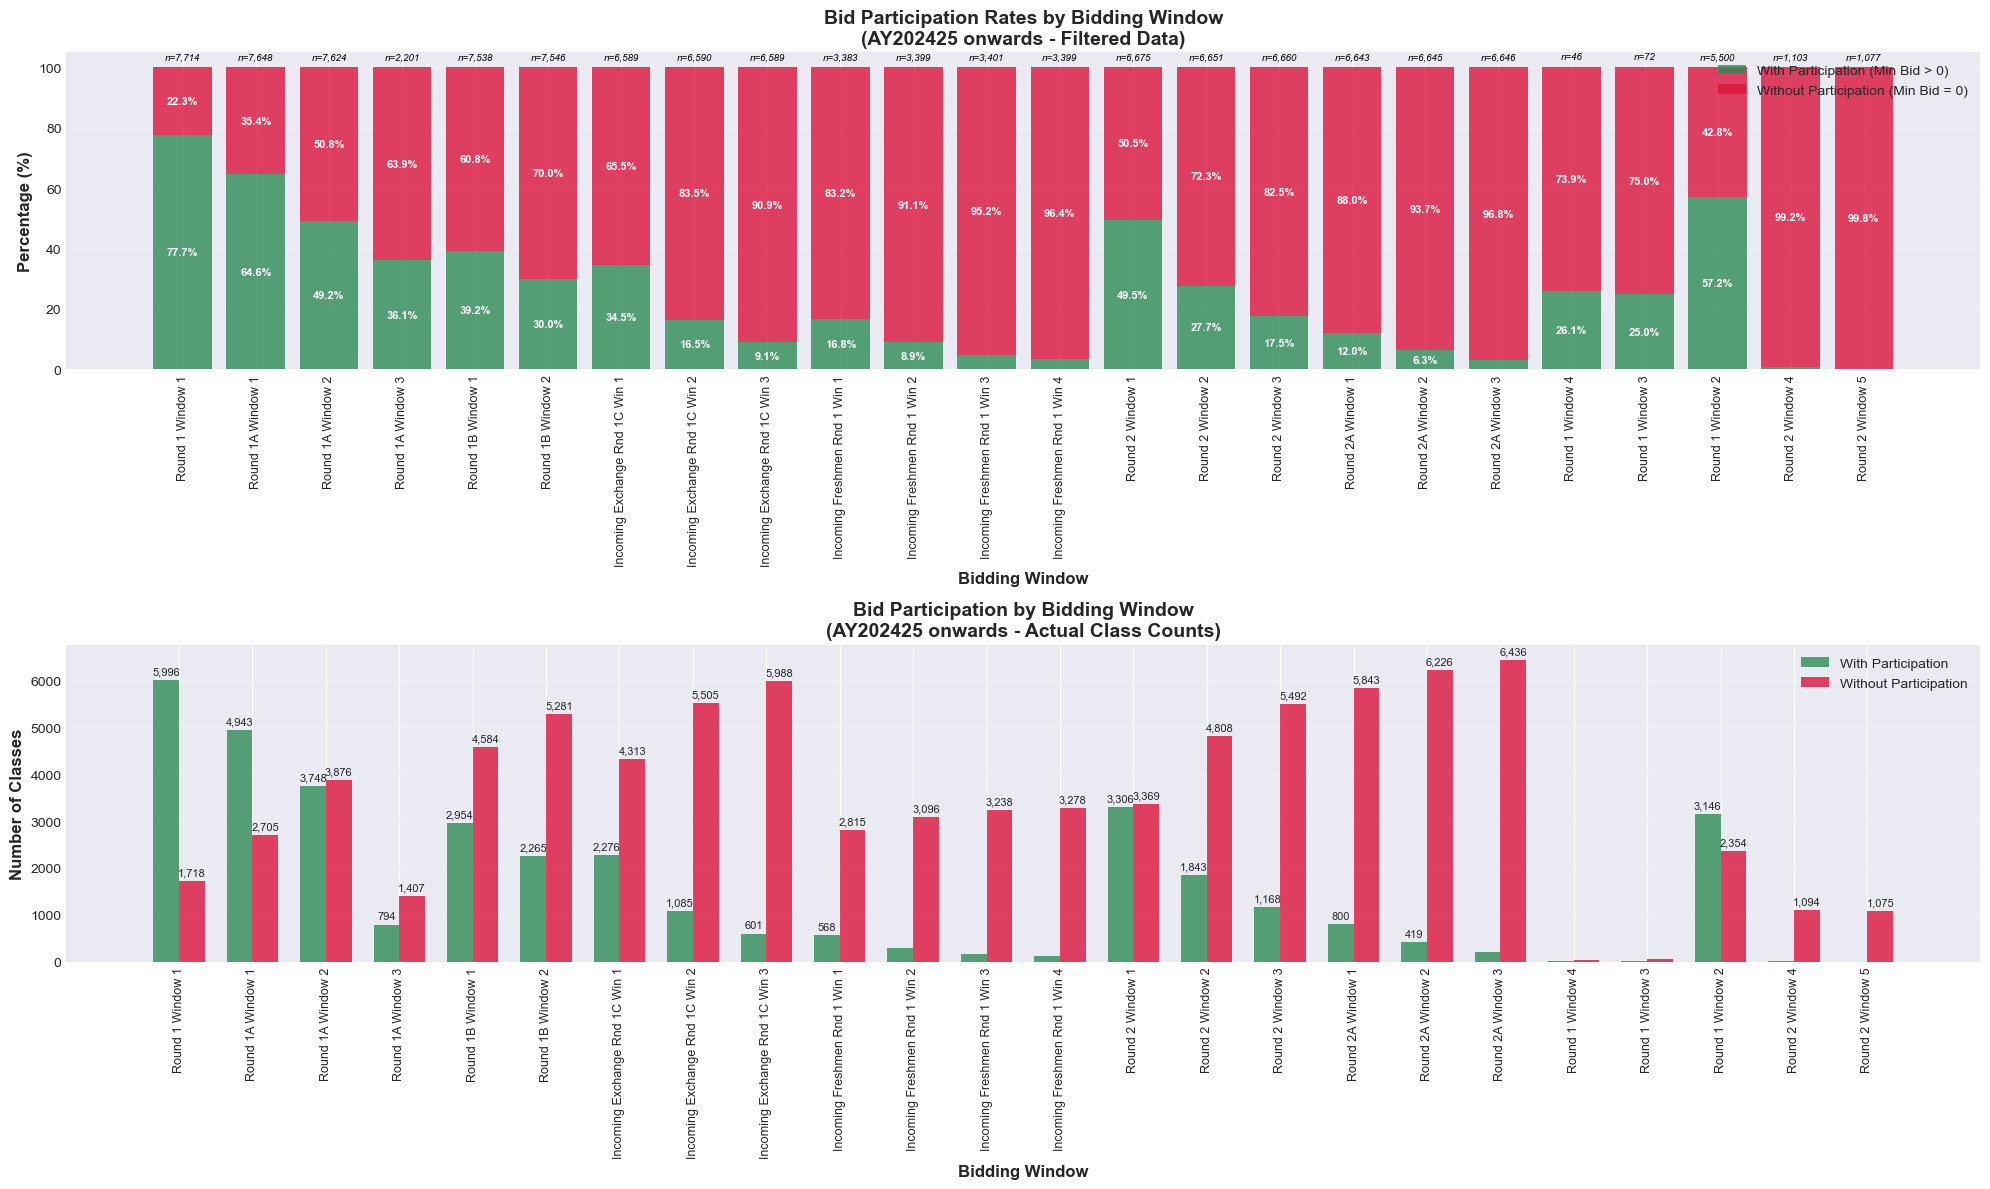


DETAILED PARTICIPATION SUMMARY BY BIDDING WINDOW (FILTERED & ORDERED)
Bidding Window                              Total     With  Without   Part % Non-Part %  Order
--------------------------------------------------------------------------------------------------------------
Round 1 Window 1                             7714     5996     1718    77.7%      22.3%      1
Round 1A Window 1                            7648     4943     2705    64.6%      35.4%      2
Round 1A Window 2                            7624     3748     3876    49.2%      50.8%      3
Round 1A Window 3                            2201      794     1407    36.1%      63.9%      4
Round 1B Window 1                            7538     2954     4584    39.2%      60.8%      5
Round 1B Window 2                            7546     2265     5281    30.0%      70.0%      6
Incoming Exchange Rnd 1C Win 1               6589     2276     4313    34.5%      65.5%     10
Incoming Exchange Rnd 1C Win 2               6590     1085

In [9]:
# Question 4: Bid Participation Analysis by Bidding Window
# Participation is defined as classes with Min Bid > 0
# Excludes AY202122T1, AY202122T2, AY202223T1, AY202223T2, AY202324T1, AY202324T2 and all T3A, T3B terms

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

# ================================
# DATA FILTERING
# ================================

# Define excluded academic terms
excluded_terms = [
    'AY202122T1', 'AY202122T2', 'AY202223T1', 'AY202223T2', 'AY202324T1', 'AY202324T2',
    'AY202122T3A', 'AY202122T3B', 'AY202223T3A', 'AY202223T3B', 'AY202324T3A', 'AY202324T3B',
    'AY202425T3A', 'AY202425T3B'
]

# Extract academic term from Source.Name
def extract_term(source_name):
    match = re.search(r'(AY\d{6}T\d+[AB]?)', source_name)
    if match:
        return match.group(1)
    return None

overall_boss['acad_term'] = overall_boss['Source.Name'].apply(extract_term)

# Filter data to exclude unwanted terms
filtered_boss = overall_boss[~overall_boss['acad_term'].isin(excluded_terms)].copy()

# Also exclude T3A and T3B terms explicitly by Term column
filtered_boss = filtered_boss[~filtered_boss['Term'].isin(['T3A', 'T3B'])].copy()

print(f"Original data: {len(overall_boss):,} records")
print(f"After filtering: {len(filtered_boss):,} records")
print(f"Excluded terms: {excluded_terms}")

# ================================
# CUSTOM BIDDING WINDOW ORDERING
# ================================

def get_bidding_window_order(bidding_window):
    """
    Custom ordering function for AY202425T1 and onwards pattern
    """
    # Order based on AY202425T1 and AY202425T2 onwards pattern
    order_map = {
        'Round 1 Window 1': 1,
        'Round 1A Window 1': 2,
        'Round 1A Window 2': 3,
        'Round 1A Window 3': 4,
        'Round 1B Window 1': 5,
        'Round 1B Window 2': 6,
        'Round 1C Window 1': 7,
        'Round 1C Window 2': 8,
        'Round 1C Window 3': 9,
        'Incoming Exchange Rnd 1C Win 1': 10,
        'Incoming Exchange Rnd 1C Win 2': 11,
        'Incoming Exchange Rnd 1C Win 3': 12,
        'Incoming Freshmen Rnd 1 Win 1': 13,
        'Incoming Freshmen Rnd 1 Win 2': 14,
        'Incoming Freshmen Rnd 1 Win 3': 15,
        'Incoming Freshmen Rnd 1 Win 4': 16,
        'Round 2 Window 1': 17,
        'Round 2 Window 2': 18,
        'Round 2 Window 3': 19,
        'Round 2A Window 1': 20,
        'Round 2A Window 2': 21,
        'Round 2A Window 3': 22
    }
    
    # Return the order if found, otherwise return a high number for unknown windows
    return order_map.get(bidding_window, 9999)

# ================================
# DATA PREPARATION
# ================================

# Create participation flag (Min Bid > 0 means participated)
filtered_boss['participated'] = filtered_boss['Min Bid'] > 0

# Group by Bidding Window and calculate participation statistics
participation_data = filtered_boss.groupby('Bidding Window').agg({
    'Course Code': 'count',  # Total classes
    'participated': 'sum'    # Classes with participation (Min Bid > 0)
}).reset_index()

participation_data.columns = ['Bidding Window', 'total_classes', 'classes_with_participation']

# Calculate classes without participation
participation_data['classes_without_participation'] = (
    participation_data['total_classes'] - participation_data['classes_with_participation']
)

# Calculate participation rate as percentage
participation_data['participation_rate'] = (
    participation_data['classes_with_participation'] / participation_data['total_classes'] * 100
)

# Calculate non-participation rate as percentage
participation_data['non_participation_rate'] = (
    participation_data['classes_without_participation'] / participation_data['total_classes'] * 100
)

# Add custom ordering column
participation_data['custom_order'] = participation_data['Bidding Window'].apply(get_bidding_window_order)

# Sort by custom order instead of alphabetical
participation_data = participation_data.sort_values('custom_order').reset_index(drop=True)

# ================================
# VERIFICATION
# ================================

total_non_participation = participation_data['classes_without_participation'].sum()
total_classes = participation_data['total_classes'].sum()
overall_participation_rate = participation_data['classes_with_participation'].sum() / total_classes * 100

print("\n" + "="*80)
print("PARTICIPATION ANALYSIS VERIFICATION")
print("="*80)
print(f"Total classes (after filtering): {total_classes:,}")
print(f"Total non-participation: {total_non_participation:,}")
print(f"Overall participation rate: {overall_participation_rate:.1f}%")

# Show academic terms included in analysis
included_terms = sorted(filtered_boss['acad_term'].dropna().unique())
print(f"\nIncluded academic terms: {included_terms}")

# Show first few windows to verify ordering
print(f"\nOrdering Verification (showing custom order):")
print(f"{'Bidding Window':<40} {'Order':>6} {'Classes':>8}")
print("-" * 60)
for i in range(min(15, len(participation_data))):
    row = participation_data.iloc[i]
    print(f"{row['Bidding Window']:<40} {int(row['custom_order']):>6} {int(row['total_classes']):>8}")

# ================================
# ENHANCED VISUALIZATION
# ================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))

# ================================
# Chart 1: Stacked Bar Chart with Percentages
# ================================

x_pos = np.arange(len(participation_data))
width = 0.8

# Create stacked bars
bars1 = ax1.bar(x_pos, participation_data['participation_rate'], 
                width, label='With Participation (Min Bid > 0)', color='#2E8B57', alpha=0.8)
bars2 = ax1.bar(x_pos, participation_data['non_participation_rate'], 
                width, bottom=participation_data['participation_rate'],
                label='Without Participation (Min Bid = 0)', color='#DC143C', alpha=0.8)

# Customize first chart
ax1.set_xlabel('Bidding Window', fontsize=12, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax1.set_title('Bid Participation Rates by Bidding Window\n(AY202425 onwards - Filtered Data)', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(participation_data['Bidding Window'], rotation=90, ha='center', fontsize=9)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 105)

# Add percentage labels on bars
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Participation percentage label (center of green section)
    height1 = bar1.get_height()
    if height1 > 5:  # Only show label if section is large enough
        ax1.text(bar1.get_x() + bar1.get_width()/2, height1/2, 
                f'{height1:.1f}%', ha='center', va='center', 
                fontsize=8, fontweight='bold', color='white')
    
    # Non-participation percentage label (center of red section)
    height2 = bar2.get_height()
    if height2 > 5:  # Only show label if section is large enough
        ax1.text(bar2.get_x() + bar2.get_width()/2, height1 + height2/2, 
                f'{height2:.1f}%', ha='center', va='center', 
                fontsize=8, fontweight='bold', color='white')
    
    # Total classes count on top
    total_classes_val = participation_data.iloc[i]['total_classes']
    ax1.text(bar2.get_x() + bar2.get_width()/2, 102, 
            f'n={total_classes_val:,}', ha='center', va='bottom', 
            fontsize=7, color='black', style='italic')

# ================================
# Chart 2: Actual Numbers Comparison
# ================================

# Create grouped bar chart for actual numbers
x_pos2 = np.arange(len(participation_data))
width2 = 0.35

bars3 = ax2.bar(x_pos2 - width2/2, participation_data['classes_with_participation'], 
                width2, label='With Participation', color='#2E8B57', alpha=0.8)
bars4 = ax2.bar(x_pos2 + width2/2, participation_data['classes_without_participation'], 
                width2, label='Without Participation', color='#DC143C', alpha=0.8)

# Customize second chart
ax2.set_xlabel('Bidding Window', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Classes', fontsize=12, fontweight='bold')
ax2.set_title('Bid Participation by Bidding Window\n(AY202425 onwards - Actual Class Counts)', 
              fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(participation_data['Bidding Window'], rotation=90, ha='center', fontsize=9)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars (selective labeling to avoid clutter)
max_height = max(participation_data['total_classes'].max(), participation_data['classes_without_participation'].max())
threshold = max_height * 0.05  # Only show labels for bars > 5% of max height

for bar in bars3:
    height = bar.get_height()
    if height > threshold:
        ax2.text(bar.get_x() + bar.get_width()/2, height + (max_height * 0.01), 
                f'{int(height):,}', ha='center', va='bottom', fontsize=8)

for bar in bars4:
    height = bar.get_height()
    if height > threshold:
        ax2.text(bar.get_x() + bar.get_width()/2, height + (max_height * 0.01), 
                f'{int(height):,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# ================================
# DETAILED SUMMARY TABLE
# ================================

print("\n" + "="*110)
print("DETAILED PARTICIPATION SUMMARY BY BIDDING WINDOW (FILTERED & ORDERED)")
print("="*110)

# Create summary table with custom order
summary_table = participation_data[['Bidding Window', 'total_classes', 'classes_with_participation', 
                                   'classes_without_participation', 'participation_rate', 
                                   'non_participation_rate', 'custom_order']].copy()

summary_table.columns = ['Bidding Window', 'Total Classes', 'With Participation', 
                        'Without Participation', 'Participation %', 'Non-Participation %', 'Order']

print(f"{'Bidding Window':<40} {'Total':>8} {'With':>8} {'Without':>8} {'Part %':>8} {'Non-Part %':>10} {'Order':>6}")
print("-" * 110)

for _, row in summary_table.iterrows():
    print(f"{row['Bidding Window']:<40} "
          f"{int(row['Total Classes']):>8} "
          f"{int(row['With Participation']):>8} "
          f"{int(row['Without Participation']):>8} "
          f"{row['Participation %']:>7.1f}% "
          f"{row['Non-Participation %']:>9.1f}% "
          f"{int(row['Order']):>6}")

# ================================
# KEY INSIGHTS
# ================================

print("\n" + "="*80)
print("KEY INSIGHTS (FILTERED DATA)")
print("="*80)

# Find windows with highest and lowest participation
if len(participation_data) > 0:
    highest_participation = participation_data.loc[participation_data['participation_rate'].idxmax()]
    lowest_participation = participation_data.loc[participation_data['participation_rate'].idxmin()]

    print(f"\nParticipation Rate Analysis:")
    print(f"• Highest Participation: {highest_participation['Bidding Window']} ({highest_participation['participation_rate']:.1f}%)")
    print(f"• Lowest Participation: {lowest_participation['Bidding Window']} ({lowest_participation['participation_rate']:.1f}%)")
    print(f"• Average Participation Rate: {participation_data['participation_rate'].mean():.1f}%")
    print(f"• Median Participation Rate: {participation_data['participation_rate'].median():.1f}%")
    print(f"• Participation Rate Range: {participation_data['participation_rate'].min():.1f}% - {participation_data['participation_rate'].max():.1f}%")

    # Classes analysis
    print(f"\nClass Distribution Analysis:")
    print(f"• Total Classes Across All Windows: {total_classes:,}")
    print(f"• Classes with Participation (Min Bid > 0): {participation_data['classes_with_participation'].sum():,}")
    print(f"• Classes without Participation (Min Bid = 0): {total_non_participation:,}")
    print(f"• Average Classes per Window: {participation_data['total_classes'].mean():.0f}")

    # Window with most/least classes
    most_classes = participation_data.loc[participation_data['total_classes'].idxmax()]
    least_classes = participation_data.loc[participation_data['total_classes'].idxmin()]

    print(f"\nWindow Size Analysis:")
    print(f"• Most Classes: {most_classes['Bidding Window']} ({most_classes['total_classes']:,} classes)")
    print(f"• Least Classes: {least_classes['Bidding Window']} ({least_classes['total_classes']:,} classes)")

    # Participation distribution
    print(f"\nParticipation Rate Distribution:")
    high_participation = len(participation_data[participation_data['participation_rate'] >= 80])
    medium_participation = len(participation_data[(participation_data['participation_rate'] >= 50) & 
                                                (participation_data['participation_rate'] < 80)])
    low_participation = len(participation_data[participation_data['participation_rate'] < 50])

    print(f"• High Participation (≥80%): {high_participation} windows")
    print(f"• Medium Participation (50-79%): {medium_participation} windows")
    print(f"• Low Participation (<50%): {low_participation} windows")

    # Data coverage analysis
    print(f"\nData Coverage Analysis:")
    print(f"• Total Bidding Windows Analyzed: {len(participation_data)}")
    print(f"• Academic Terms Included: {len(included_terms)}")
    print(f"• Terms: {', '.join(included_terms)}")

else:
    print("No data available after filtering.")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("• Green sections = Classes with student participation (Min Bid > 0)")
print("• Red sections = Classes without student participation (Min Bid = 0)")
print("• Analysis excludes older terms (AY202122T1/T2, AY202223T1/T2, AY202324T1/T2) and all T3A/T3B terms")
print("• Bidding windows ordered according to AY202425 onwards pattern")
print("• Round 1 starts immediately with 1A, 1B, 1C variants (no standalone Round 1 Window 2)")
print("• Top chart shows percentage distribution within each window")
print("• Bottom chart shows actual class counts for comparison")
print("• Numbers above bars indicate total classes per window (top) or count per category (bottom)")

print("\n" + "="*80)
print("DATA FILTERING SUMMARY")
print("="*80)
print("EXCLUDED:")
print("• Old bidding systems: AY202122T1, AY202122T2, AY202223T1, AY202223T2, AY202324T1, AY202324T2")
print("• Special terms: All T3A and T3B terms across all academic years")
print("INCLUDED:")
print("• AY202425T1 and AY202425T2 onwards (following new bidding window pattern)")
print("• AY202425T3B excluded as per T3B exclusion rule")

print("="*80)


Total unique classes: 14138


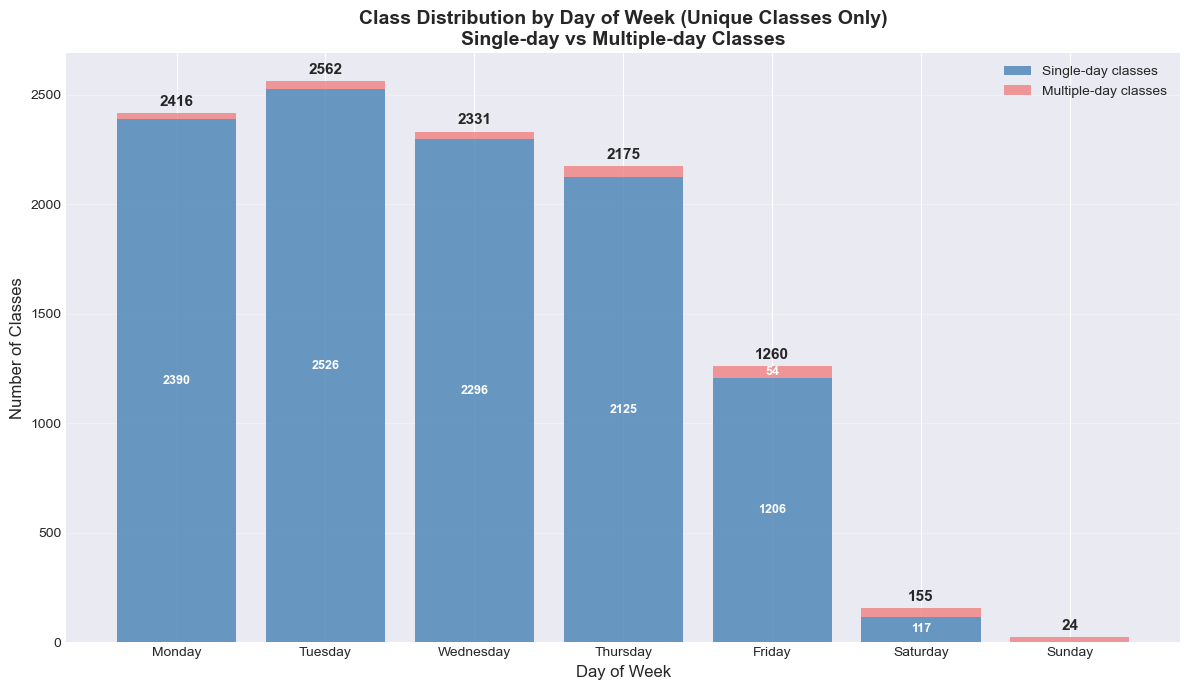


Class Distribution by Day (Unique Classes - 14138 total):
Day          Single-day   Multi-day    Total        % of Total  
----------------------------------------------------------------------
Monday       2390         26           2416         22.1       %
Tuesday      2526         36           2562         23.5       %
Wednesday    2296         35           2331         21.3       %
Thursday     2125         50           2175         19.9       %
Friday       1206         54           1260         11.5       %
Saturday     117          38           155          1.4        %
Sunday       0            24           24           0.2        %
----------------------------------------------------------------------
TOTAL        10660        263          10923        100.0%      

Insights:
• 10,660 classes (75.4%) meet on a single day
• 12615 classes meet on multiple days

Classes by number of meeting days:
  1 day: 10,660 classes (75.4%)
  2 days: 23 classes (0.2%)
  3 days: 23 classes (0

In [19]:
# Question 5: Classes per day (IMPROVED with single/multiple day breakdown)
# Join standalone_df and multiple_df on record_key
merged_df = pd.merge(standalone_df, multiple_df, on='record_key', how='left')

def parse_days(day_string):
    """Parse day_of_week string and return list of days"""
    if pd.isna(day_string) or day_string == 'TBA':
        return []
    
    days = []
    day_mapping = {
        'Mon': 'Monday', 'Tue': 'Tuesday', 'Wed': 'Wednesday',
        'Thu': 'Thursday', 'Fri': 'Friday', 'Sat': 'Saturday', 'Sun': 'Sunday'
    }
    
    day_parts = [d.strip() for d in str(day_string).split(',')]
    for part in day_parts:
        for abbr, full in day_mapping.items():
            if abbr in part:
                days.append(full)
    
    return days

# Get unique classes only (deduplicate by course_code, section, acad_term_id)
unique_classes = merged_df.drop_duplicates(subset=['course_code', 'section', 'acad_term_id'])

print(f"Total unique classes: {len(unique_classes)}")

# Count classes by day, separating single-day vs multiple-day classes
day_counts_single = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 
                    'Friday': 0, 'Saturday': 0, 'Sunday': 0}
day_counts_multiple = {'Monday': 0, 'Tuesday': 0, 'Wednesday': 0, 'Thursday': 0, 
                      'Friday': 0, 'Saturday': 0, 'Sunday': 0}

for _, row in unique_classes.iterrows():
    days = parse_days(row['day_of_week'])
    
    if len(days) == 1:
        # Single day class
        day = days[0]
        if day in day_counts_single:
            day_counts_single[day] += 1
    elif len(days) > 1:
        # Multiple day class
        for day in days:
            if day in day_counts_multiple:
                day_counts_multiple[day] += 1

# Create stacked bar chart
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
single_counts = [day_counts_single[day] for day in days_order]
multiple_counts = [day_counts_multiple[day] for day in days_order]
total_counts = [single_counts[i] + multiple_counts[i] for i in range(len(days_order))]

fig, ax = plt.subplots(figsize=(12, 7))

# Create stacked bars
bars1 = ax.bar(range(len(days_order)), single_counts, label='Single-day classes', color='steelblue', alpha=0.8)
bars2 = ax.bar(range(len(days_order)), multiple_counts, bottom=single_counts, 
               label='Multiple-day classes', color='lightcoral', alpha=0.8)

# Add total count labels on top of bars
for i, (total, single, multiple) in enumerate(zip(total_counts, single_counts, multiple_counts)):
    ax.text(i, total + 20, str(total), ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add breakdown text inside bars if there's enough space
    if single > 50:
        ax.text(i, single/2, str(single), ha='center', va='center', fontsize=9, color='white', fontweight='bold')
    if multiple > 50:
        ax.text(i, single + multiple/2, str(multiple), ha='center', va='center', fontsize=9, color='white', fontweight='bold')

ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Number of Classes', fontsize=12)
ax.set_title('Class Distribution by Day of Week (Unique Classes Only)\nSingle-day vs Multiple-day Classes', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(days_order)))
ax.set_xticklabels(days_order)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed breakdown
print(f"\nClass Distribution by Day (Unique Classes - {len(unique_classes)} total):")
print("=" * 70)
print(f"{'Day':<12} {'Single-day':<12} {'Multi-day':<12} {'Total':<12} {'% of Total':<12}")
print("-" * 70)

total_single = sum(single_counts)
total_multiple = sum(multiple_counts)
grand_total = sum(total_counts)

for day, single, multiple, total in zip(days_order, single_counts, multiple_counts, total_counts):
    percentage = (total / grand_total * 100) if grand_total > 0 else 0
    print(f"{day:<12} {single:<12} {multiple:<12} {total:<12} {percentage:<11.1f}%")

print("-" * 70)
print(f"{'TOTAL':<12} {total_single:<12} {total_multiple:<12} {grand_total:<12} {'100.0%':<12}")

# Additional insights
print(f"\nInsights:")
print(f"• {total_single:,} classes ({total_single/len(unique_classes)*100:.1f}%) meet on a single day")
print(f"• {len(unique_classes) - total_single/len(set().union(*[parse_days(row['day_of_week']) for _, row in unique_classes.iterrows() if len(parse_days(row['day_of_week'])) > 0])):.0f} classes meet on multiple days")

# Count classes by number of days they meet
day_frequency = {}
for _, row in unique_classes.iterrows():
    days = parse_days(row['day_of_week'])
    num_days = len(days)
    if num_days > 0:
        day_frequency[num_days] = day_frequency.get(num_days, 0) + 1

print(f"\nClasses by number of meeting days:")
for num_days in sorted(day_frequency.keys()):
    count = day_frequency[num_days]
    percentage = count / len(unique_classes) * 100
    print(f"  {num_days} day{'s' if num_days != 1 else ''}: {count:,} classes ({percentage:.1f}%)")

# Verify our counting
print(f"\nValidation:")
print(f"Sum of all day occurrences: {grand_total:,}")
print(f"This represents class-day combinations from {len(unique_classes):,} unique classes")

Unique classes after calculating medians: 6714
Final dataset shape: (6714, 12)


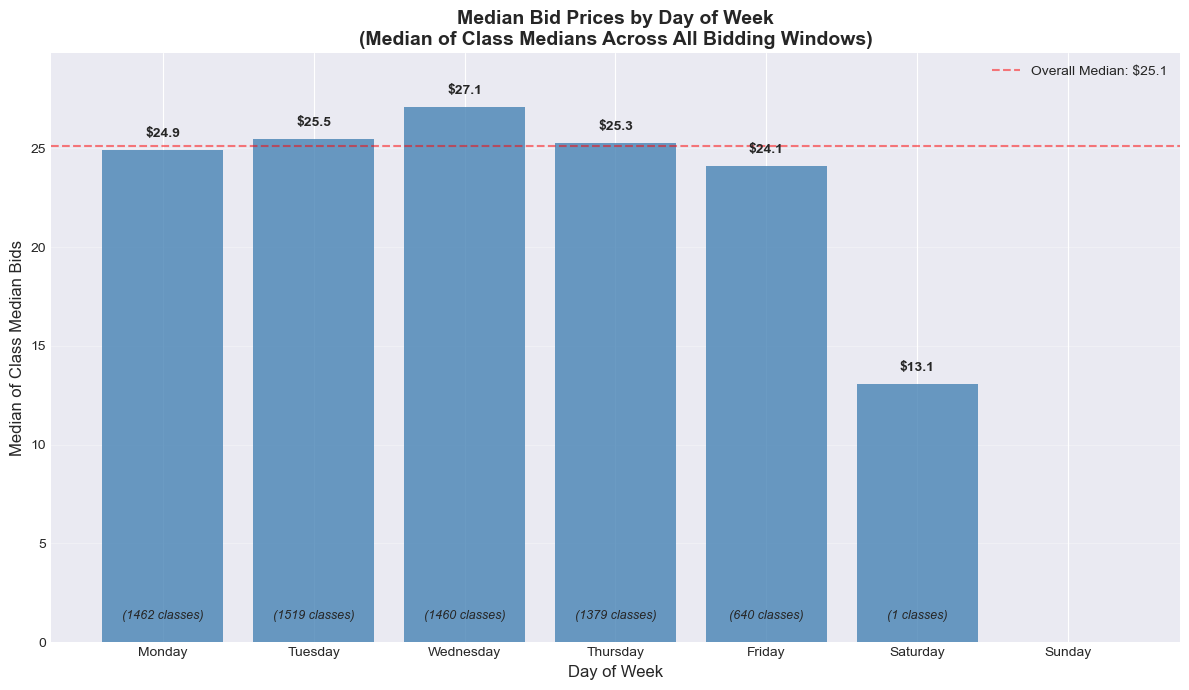


Median Bid Prices by Day of Week (Median of Class Medians):
------------------------------------------------------------
Monday    : $ 24.95 (1462 classes with bids / 1462 total)
Tuesday   : $ 25.49 (1519 classes with bids / 1519 total)
Wednesday : $ 27.12 (1460 classes with bids / 1460 total)
Thursday  : $ 25.26 (1379 classes with bids / 1379 total)
Friday    : $ 24.14 (640 classes with bids / 640 total)
Saturday  : $ 13.06 (1 classes with bids / 1 total)
Sunday    : No classes scheduled

Summary:
Highest median bid: Wednesday ($27.12)
Lowest median bid: Saturday ($13.06)
Overall median: $25.10

Validation:
Total unique classes: 6714
Classes with bids > 0: 6714
This should align better with your expected data size


In [16]:
# Question 6: Average bid prices by day_of_week (CORRECTED)

# Step 1: Merge standalone_df and multiple_df to get all bidding data
raw_data_merged = standalone_df.merge(multiple_df, on='record_key', how='left')

# Step 2: Transform acad_term_id to match overall_boss Term format
def transform_term(acad_term_id):
    """Convert AY202122T1 format to '2021-22 Term 1' format"""
    if pd.isna(acad_term_id):
        return None
    
    # Extract year and term parts
    year_part = acad_term_id[2:8]  # 202122
    term_part = acad_term_id[8:]   # T1
    
    # Format year as 20XX-YY
    start_year = year_part[:4]
    end_year = year_part[4:]
    formatted_year = f"{start_year}-{end_year}"
    
    # Map term codes
    term_mapping = {
        'T1': 'Term 1',
        'T2': 'Term 2', 
        'T3A': 'Term 3A',
        'T3B': 'Term 3B'
    }
    
    formatted_term = term_mapping.get(term_part, term_part)
    
    return f"{formatted_year} {formatted_term}"

# Apply the transformation
raw_data_merged['term_formatted'] = raw_data_merged['acad_term_id'].apply(transform_term)

# Step 3: First merge with overall_boss to get bid data, then calculate class medians
merged_with_bids = overall_boss.merge(
    raw_data_merged,
    left_on=['Course Code', 'Section', 'Term'],
    right_on=['course_code', 'section', 'term_formatted'],
    how='inner'
)

# Filter out zero bids BEFORE calculating class medians
merged_with_nonzero_bids = merged_with_bids[merged_with_bids['Median Bid'] > 0]

# Now calculate median bid across all bidding windows for each unique class
class_medians = merged_with_nonzero_bids.groupby(['course_code', 'section', 'term_formatted']).agg({
    'Median Bid': 'median',
    'day_of_week': 'first'
}).reset_index()

# Rename the median bid column for clarity
class_medians.rename(columns={'Median Bid': 'class_median_bid'}, inplace=True)

print(f"Unique classes after calculating medians: {len(class_medians)}")

# Step 4: Extract day information from day_of_week column
def parse_days(day_string):
    """Parse day_of_week string into individual day flags"""
    day_flags = {
        'has_mon': 0, 'has_tue': 0, 'has_wed': 0, 'has_thu': 0,
        'has_fri': 0, 'has_sat': 0, 'has_sun': 0
    }
    
    if pd.isna(day_string) or day_string == '':
        return day_flags
    
    # Map day abbreviations to flag names
    day_mapping = {
        'Mon': 'has_mon', 'Tue': 'has_tue', 'Wed': 'has_wed', 'Thu': 'has_thu',
        'Fri': 'has_fri', 'Sat': 'has_sat', 'Sun': 'has_sun'
    }
    
    # Split and clean the day string
    days = [day.strip() for day in day_string.split(',')]
    
    for day in days:
        if day in day_mapping:
            day_flags[day_mapping[day]] = 1
    
    return day_flags

# Apply day parsing to create day flags
day_flags_df = class_medians['day_of_week'].apply(parse_days).apply(pd.Series)
class_data_with_days = pd.concat([class_medians, day_flags_df], axis=1)

print(f"Final dataset shape: {class_data_with_days.shape}")

# Step 5: Calculate median of class medians by day of week
day_columns = ['has_mon', 'has_tue', 'has_wed', 'has_thu', 'has_fri', 'has_sat', 'has_sun']
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_stats = []

for day_col, day_name in zip(day_columns, day_names):
    # Get all classes that have sessions on this day
    classes_on_day = class_data_with_days[class_data_with_days[day_col] == 1]
    
    if len(classes_on_day) > 0:
        # Filter out classes with 0 bids to get meaningful median
        classes_with_bids = classes_on_day[classes_on_day['class_median_bid'] > 0]
        
        if len(classes_with_bids) > 0:
            # Calculate median of the class medians for this day
            day_median_bid = classes_with_bids['class_median_bid'].median()
            
            day_stats.append({
                'day': day_name,
                'median_bid': day_median_bid,
                'count_with_bids': len(classes_with_bids),
                'total_classes': len(classes_on_day)
            })
        else:
            # All classes had 0 bids
            day_stats.append({
                'day': day_name,
                'median_bid': 0,
                'count_with_bids': 0,
                'total_classes': len(classes_on_day)
            })
    else:
        # No classes on this day
        day_stats.append({
            'day': day_name,
            'median_bid': 0,
            'count_with_bids': 0,
            'total_classes': 0
        })

day_stats_df = pd.DataFrame(day_stats)

# Create bar chart
fig, ax = plt.subplots(figsize=(12, 7))

x_pos = np.arange(len(day_stats_df))
bars = ax.bar(x_pos, day_stats_df['median_bid'], color='steelblue', alpha=0.8)

# Add values on bars
for i, (bar, val, count) in enumerate(zip(bars, day_stats_df['median_bid'], day_stats_df['count_with_bids'])):
    if val > 0:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'${val:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        # Add count below bar
        ax.text(bar.get_x() + bar.get_width()/2, 1, 
                f'({int(count)} classes)', ha='center', va='bottom', fontsize=9, style='italic')

# Find and highlight the overall median
non_zero_medians = day_stats_df[day_stats_df['median_bid'] > 0]['median_bid']
if len(non_zero_medians) > 0:
    overall_median = non_zero_medians.median()
    median_line = ax.axhline(y=overall_median, color='red', linestyle='--', alpha=0.5, 
                            label=f'Overall Median: ${overall_median:.1f}')
    ax.legend()

# Customize plot
ax.set_xlabel('Day of Week', fontsize=12)
ax.set_ylabel('Median of Class Median Bids', fontsize=12)
ax.set_title('Median Bid Prices by Day of Week\n(Median of Class Medians Across All Bidding Windows)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(day_stats_df['day'])
ax.grid(axis='y', alpha=0.3)

# Set y-axis to start from 0
if day_stats_df['median_bid'].max() > 0:
    ax.set_ylim(0, day_stats_df['median_bid'].max() * 1.1)

plt.tight_layout()
plt.show()

# Print detailed results
print('\nMedian Bid Prices by Day of Week (Median of Class Medians):')
print('-' * 60)
for _, row in day_stats_df.iterrows():
    if row['median_bid'] > 0:
        print(f"{row['day']:<10}: ${row['median_bid']:>6.2f} ({int(row['count_with_bids'])} classes with bids / {int(row['total_classes'])} total)")
    else:
        if row['total_classes'] > 0:
            print(f"{row['day']:<10}: No bidding data ({int(row['total_classes'])} classes with 0 bids)")
        else:
            print(f"{row['day']:<10}: No classes scheduled")

# Additional analysis
print(f"\nSummary:")
if len(non_zero_medians) > 0:
    highest_idx = day_stats_df['median_bid'].idxmax()
    print(f"Highest median bid: {day_stats_df.loc[highest_idx, 'day']} "
          f"(${day_stats_df.loc[highest_idx, 'median_bid']:.2f})")
    
    lowest_idx = day_stats_df[day_stats_df['median_bid'] > 0]['median_bid'].idxmin()
    lowest_day_idx = day_stats_df[day_stats_df['median_bid'] == day_stats_df[day_stats_df['median_bid'] > 0]['median_bid'].min()].index[0]
    print(f"Lowest median bid: {day_stats_df.loc[lowest_day_idx, 'day']} "
          f"(${day_stats_df.loc[lowest_day_idx, 'median_bid']:.2f})")
    
    print(f"Overall median: ${overall_median:.2f}")
else:
    print("No bidding data available")

# Validation
print(f"\nValidation:")
print(f"Total unique classes: {len(class_medians)}")
print(f"Classes with bids > 0: {len(class_medians[class_medians['class_median_bid'] > 0])}")
print("This should align better with your expected data size")

Using all available data: 121339 records
Available terms: ['2021-22 Term 2', '2021-22 Term 3B', '2022-23 Term 1', '2022-23 Term 2', '2022-23 Term 3A', '2022-23 Term 3B', '2023-24 Term 1', '2023-24 Term 2', '2023-24 Term 3A', '2023-24 Term 3B', '2024-25 Term 1', '2024-25 Term 2', '2024-25 Term 3A', '2024-25 Term 3B']


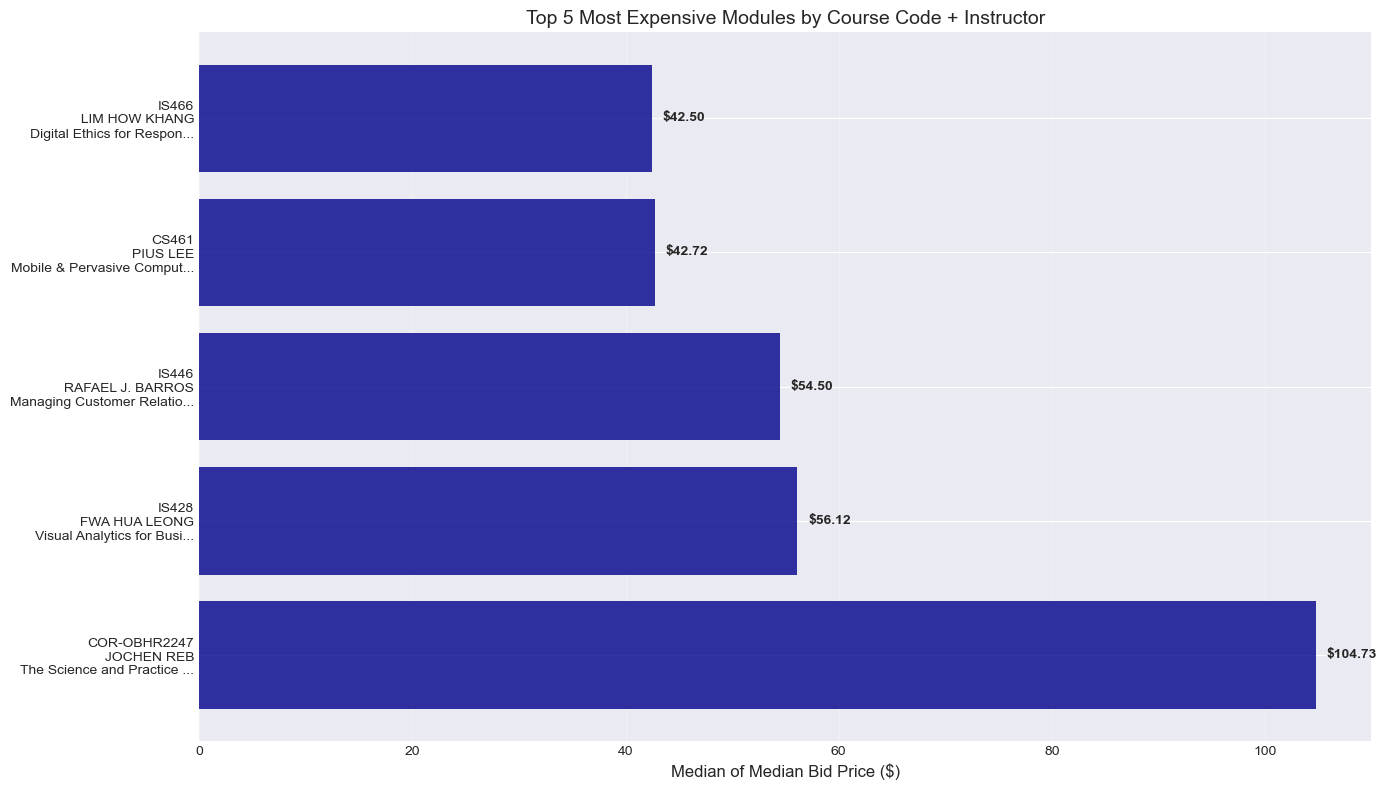

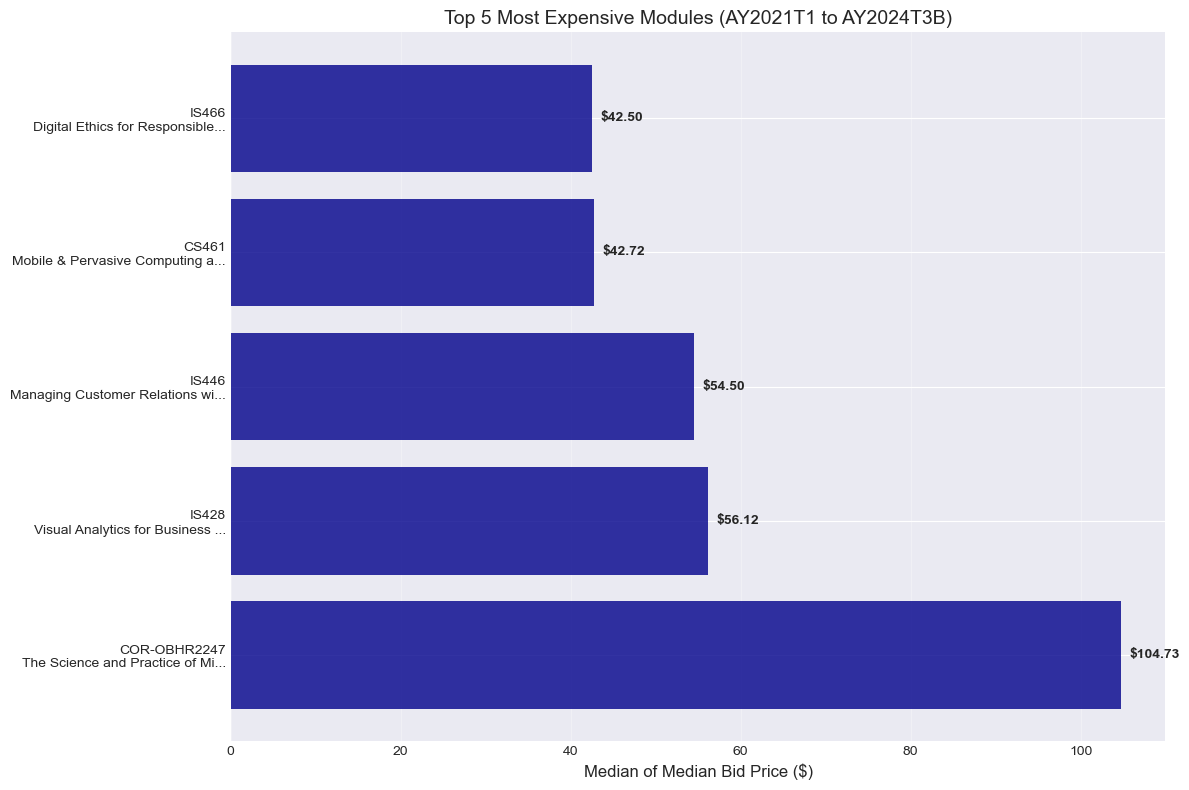


DETAILED BREAKDOWN FOR TOP 5 MODULES:

1. COR-OBHR2247 - The Science and Practice of Mindfulness at Work
Instructor:  JOCHEN REB
Median of Median Bid: $104.73
--------------------------------------------------------------------------------
Term            Session                   Bidding Window       Section  Median Bid   Min Bid    Enrolled  
--------------------------------------------------------------------------------------------------------------
2024-25 Term 2  Regular Academic Session  Round 1 Window 1     G1       $30.99       $25.01     38        
2024-25 Term 2  Regular Academic Session  Round 1A Window 1    G1       $100.00      $100.00    38        
2024-25 Term 2  Regular Academic Session  Round 1A Window 2    G1       $109.47      $108.00    40        
2024-25 Term 2  Regular Academic Session  Round 1A Window 3    G1       $160.00      $160.00    40        
2024-25 Term 2  Regular Academic Session  Round 1B Window 1    G1       $161.51      $121.88    43        
2024-2

In [ ]:
# Question 7: Top 5 most expensive mods between AY2021T1 to AY2024T3B

# Filter data for the specified period
# Use all available data since overall_boss already contains the relevant period
period_data = overall_boss.copy()

print(f"Using all available data: {len(period_data)} records")
print(f"Available terms: {sorted(period_data['Term'].unique())}")

# Group by course code + instructor to get median bid prices across all bidding rounds
course_stats = period_data.groupby(['Course Code', 'Description', 'Instructor']).agg({
    'Median Bid': ['median', 'max', 'count'],
    'Min Bid': ['median', 'max'],
    'Section': 'count'  # Number of sections
}).reset_index()

course_stats.columns = ['course_code', 'description', 'instructor', 'median_median', 'max_median', 
                       'bid_count', 'median_min', 'max_min', 'section_count']

# Filter out courses with very few bids
course_stats = course_stats[course_stats['bid_count'] >= 3]

# Sort by median of median bid
top_expensive = course_stats.nlargest(5, 'median_median')

# Filter out courses with very few bids
course_stats = course_stats[course_stats['bid_count'] >= 3]

# Sort by median of median bid
top_expensive = course_stats.nlargest(5, 'median_median')

# Create visualization
fig, ax = plt.subplots(figsize=(14, 8))

courses = [f"{row['course_code']}\n{row['instructor']}\n{row['description'][:25]}..." 
          if len(row['description']) > 25 else f"{row['course_code']}\n{row['instructor']}\n{row['description']}" 
          for _, row in top_expensive.iterrows()]

y_pos = np.arange(len(courses))

bars = ax.barh(y_pos, top_expensive['median_median'], color='darkblue', alpha=0.8)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_expensive['median_median'])):
   ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
           f'${val:.2f}', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(courses)
ax.set_xlabel('Median of Median Bid Price ($)', fontsize=12)
ax.set_title('Top 5 Most Expensive Modules by Course Code + Instructor', fontsize=14)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

courses = [f"{row['course_code']}\n{row['description'][:30]}..." 
          if len(row['description']) > 30 else f"{row['course_code']}\n{row['description']}" 
          for _, row in top_expensive.iterrows()]

y_pos = np.arange(len(courses))

bars = ax.barh(y_pos, top_expensive['median_median'], color='darkblue', alpha=0.8)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_expensive['median_median'])):
   ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
           f'${val:.2f}', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(courses)
ax.set_xlabel('Median of Median Bid Price ($)', fontsize=12)
ax.set_title('Top 5 Most Expensive Modules (AY2021T1 to AY2024T3B)', fontsize=14)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed breakdown for each top expensive module
print("\n" + "="*100)
print("DETAILED BREAKDOWN FOR TOP 5 MODULES:")
print("="*100)

for rank, (_, row) in enumerate(top_expensive.iterrows(), 1):
    print(f"\n{rank}. {row['course_code']} - {row['description']}")
    print(f"Instructor: {row['instructor']}")
    print(f"Median of Median Bid: ${row['median_median']:.2f}")
    print("-" * 80)
    
    # Get all records for this specific course-instructor combination
    details = period_data[
        (period_data['Course Code'] == row['course_code']) & 
        (period_data['Instructor'] == row['instructor'])
    ].copy()
    
    # Sort by term and bidding window for chronological order
    details = details.sort_values(['Term', 'Bidding Window', 'Section'])
    
    print(f"{'Term':<15} {'Session':<25} {'Bidding Window':<20} {'Section':<8} {'Median Bid':<12} {'Min Bid':<10} {'Enrolled':<10}")
    print("-" * 110)
    
    for _, detail in details.iterrows():
        print(f"{detail['Term']:<15} {detail['Session'][:24]:<25} {detail['Bidding Window']:<20} "
              f"{detail['Section']:<8} ${detail['Median Bid']:<11.2f} ${detail['Min Bid']:<9.2f} {detail['Enrolled Students']:<10}")
    
    # Summary statistics for this course-instructor
    print(f"\nSummary for {row['course_code']} ({row['instructor']}):")
    print(f"  Total records: {len(details)}")
    print(f"  Unique terms: {details['Term'].nunique()}")
    print(f"  Unique sections: {details['Section'].nunique()}")
    print(f"  Median bid range: ${details['Median Bid'].min():.2f} - ${details['Median Bid'].max():.2f}")
    print(f"  Average enrollment: {details['Enrolled Students'].mean():.1f} students")
    
    if rank < len(top_expensive):  # Don't add extra spacing after last item
        print("\n" + "="*50)


Top 5 Highest Individual Bids (AY2021T1 to AY2024T3B):

13504. LAW429 Section G61 - Corporate Insolvency Law
   Median Bid: $354.58
   Min Bid: $354.58
   Instructor:  STEPHEN BULL
   Term: 2021-22 Term 2
   Bidding Window: Round 1 Window 2

87688. IS446 Section G2 - Managing Customer Relations with Analytics: Asian Insights
   Median Bid: $300.99
   Min Bid: $300.99
   Instructor:  RAFAEL J. BARROS
   Term: 2023-24 Term 2
   Bidding Window: Round 1 Window 2

14554. LAW428 Section G61 - Family Law
   Median Bid: $300.00
   Min Bid: $261.00
   Instructor:  CHAN WING CHEONG
   Term: 2021-22 Term 2
   Bidding Window: Round 1 Window 1

116167. COR-LAW2237 Section G61 - Introduction to Sustainability Law
   Median Bid: $288.00
   Min Bid: $288.00
   Instructor:  LIU NENGYE, MICHELLE LIM
   Term: 2024-25 Term 2
   Bidding Window: Round 1B Window 1

50423. LAW428 Section G61 - Family Law
   Median Bid: $271.00
   Min Bid: $126.00
   Instructor:  CHAN WING CHEONG
   Term: 2022-23 Term 2
   Bi

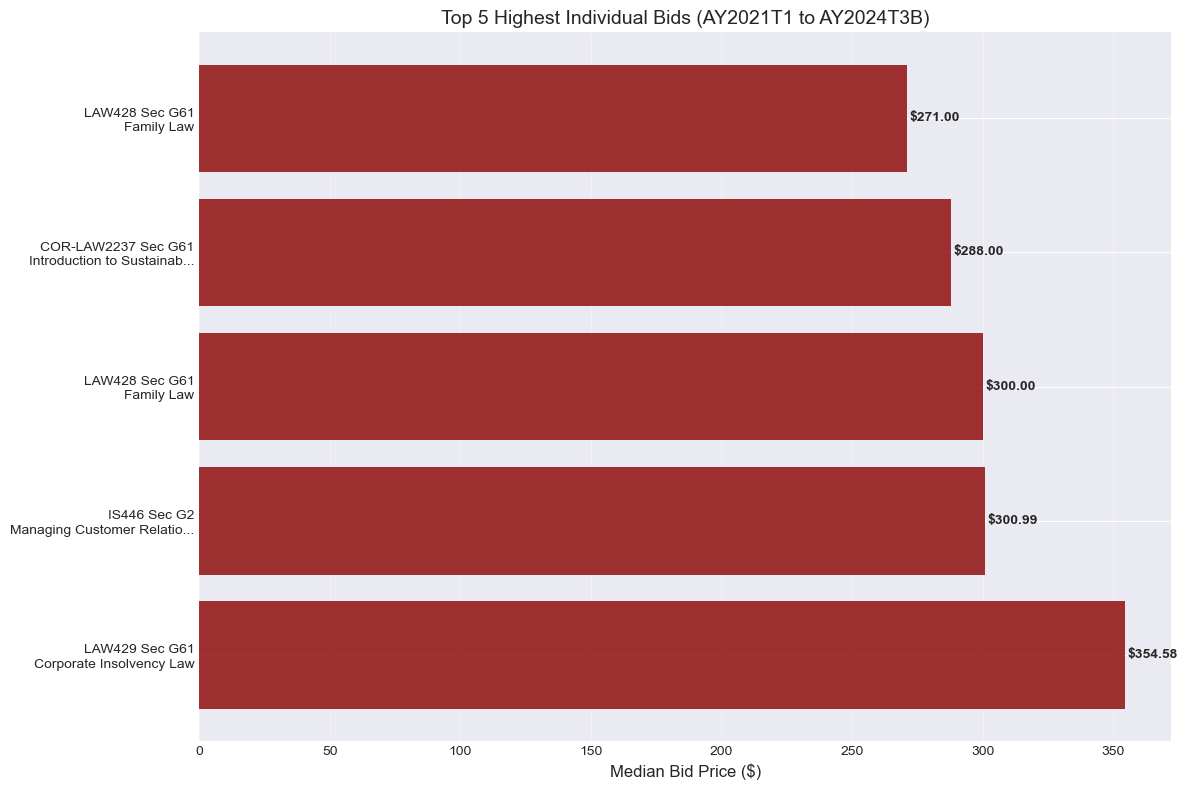

In [ ]:
# Question 8: Top 5 highest bids between AY2021T1 to AY2024T3B

# Find individual class sections with highest bids
highest_bids = period_data[period_data['Median Bid'] > 0].nlargest(5, 'Median Bid')[
    ['Course Code', 'Description', 'Section', 'Median Bid', 'Min Bid', 
     'Instructor', 'Term', 'Bidding Window']
].copy()

print("\nTop 5 Highest Individual Bids (AY2021T1 to AY2024T3B):")
print("="*80)

for idx, row in highest_bids.iterrows():
    print(f"\n{idx+1}. {row['Course Code']} Section {row['Section']} - {row['Description']}")
    print(f"   Median Bid: ${row['Median Bid']:.2f}")
    print(f"   Min Bid: ${row['Min Bid']:.2f}")
    print(f"   Instructor: {row['Instructor']}")
    print(f"   Term: {row['Term']}")
    print(f"   Bidding Window: {row['Bidding Window']}")

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

courses = [f"{row['Course Code']} Sec {row['Section']}\n{row['Description'][:25]}..." 
           if len(row['Description']) > 25 else f"{row['Course Code']} Sec {row['Section']}\n{row['Description']}" 
           for _, row in highest_bids.iterrows()]

y_pos = np.arange(len(courses))

bars = ax.barh(y_pos, highest_bids['Median Bid'], color='darkred', alpha=0.8)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, highest_bids['Median Bid'])):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
            f'${val:.2f}', ha='left', va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_pos)
ax.set_yticklabels(courses)
ax.set_xlabel('Median Bid Price ($)', fontsize=12)
ax.set_title('Top 5 Highest Individual Bids (AY2021T1 to AY2024T3B)', fontsize=14)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


Top 5 Most Expensive Predictions for AY2025 T1:

395. MGMT330 Section G4 - The Design of Business
   Predicted Median Bid: $103.21
   Predicted Min Bid: $27.53
   Instructor: ["Derrick KON"]
   Round 1 Window 1
   Before Process Vacancy: 48

579. MGMT330 Section G8 - The Design of Business
   Predicted Median Bid: $102.89
   Predicted Min Bid: $55.51
   Instructor: ["Adam GERARD"]
   Round 1 Window 1
   Before Process Vacancy: 48

578. MGMT330 Section G7 - The Design of Business
   Predicted Median Bid: $100.70
   Predicted Min Bid: $29.84
   Instructor: ["Cecil ANG"]
   Round 1 Window 1
   Before Process Vacancy: 48

577. MGMT330 Section G6 - The Design of Business
   Predicted Median Bid: $98.62
   Predicted Min Bid: $50.86
   Instructor: ["Josephine KANG"]
   Round 1 Window 1
   Before Process Vacancy: 48

1005. IS459 Section G1 - Big Data Architecture
   Predicted Median Bid: $92.78
   Predicted Min Bid: $97.40
   Instructor: ["Sachin GUPTA"]
   Round 1 Window 1
   Before Process 

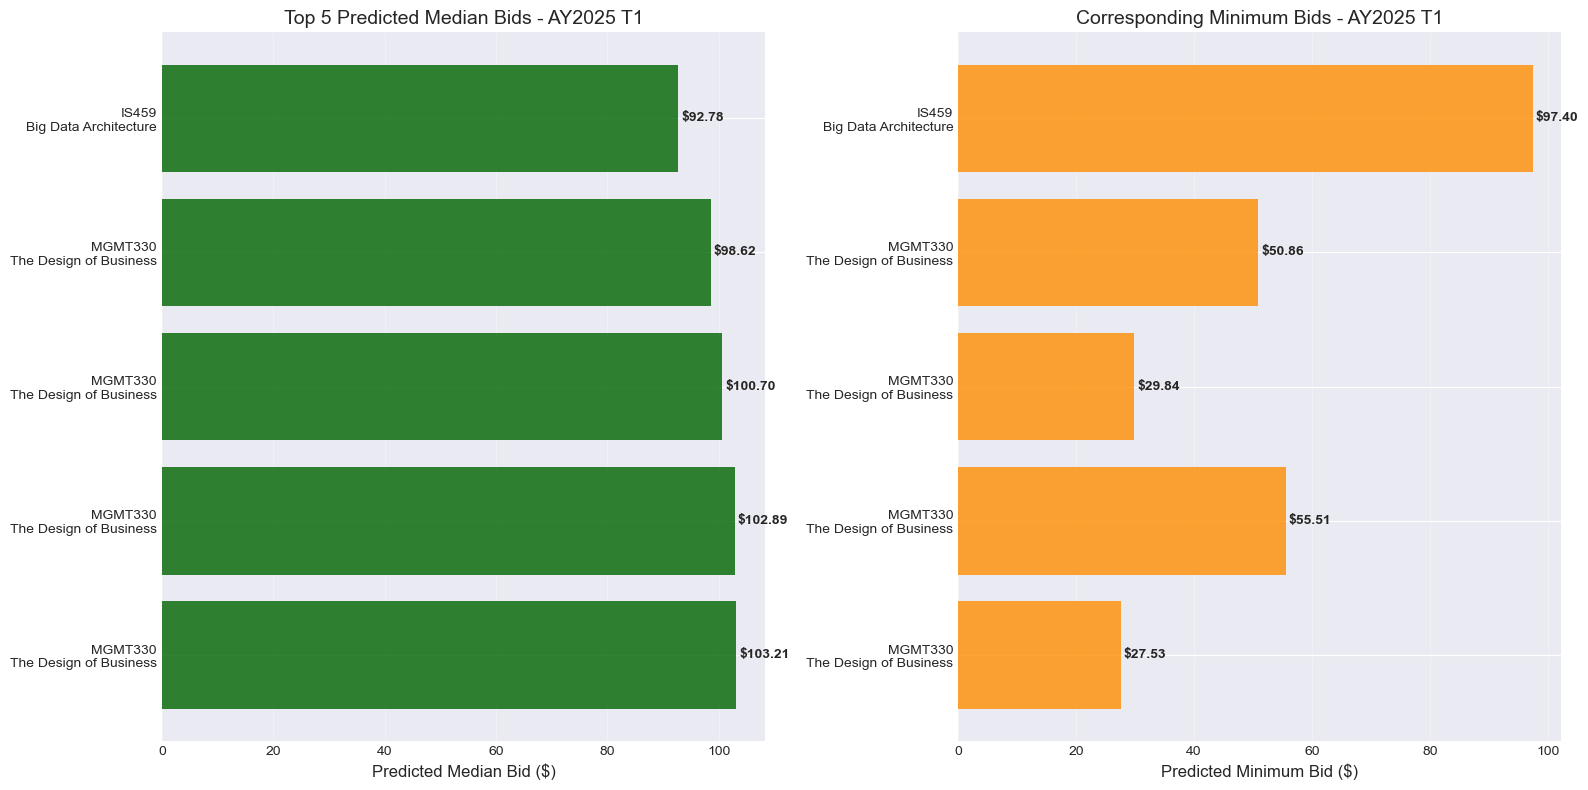


Prediction Uncertainty Analysis:

MGMT330:
   Median Bid Uncertainty: ±$20.58
   Min Bid Uncertainty: ±$10.98

MGMT330:
   Median Bid Uncertainty: ±$20.58
   Min Bid Uncertainty: ±$10.98

MGMT330:
   Median Bid Uncertainty: ±$20.58
   Min Bid Uncertainty: ±$10.98

MGMT330:
   Median Bid Uncertainty: ±$20.58
   Min Bid Uncertainty: ±$10.98

IS459:
   Median Bid Uncertainty: ±$22.82
   Min Bid Uncertainty: ±$23.78


In [ ]:
# Question 9: Top 5 most expensive predictions for AY2025 T1

# Filter predictions for AY2025 T1
predictions_2025_t1 = predictions[
    (predictions['acad_year_start'] == 2025) & 
    (predictions['term'] == 'T1')
].copy()

# Get top 5 by predicted median bid
top_predictions = predictions_2025_t1.nlargest(5, 'median_predicted')[
    ['course_code', 'course_name', 'section', 'median_predicted', 'min_predicted', 
     'instructor', 'round', 'window', 'before_process_vacancy']
].copy()

print("\nTop 5 Most Expensive Predictions for AY2025 T1:")
print("="*80)

for idx, row in top_predictions.iterrows():
    print(f"\n{idx+1}. {row['course_code']} Section {row['section']} - {row['course_name']}")
    print(f"   Predicted Median Bid: ${row['median_predicted']:.2f}")
    print(f"   Predicted Min Bid: ${row['min_predicted']:.2f}")
    print(f"   Instructor: {row['instructor']}")
    print(f"   Round {row['round']} Window {row['window']}")
    print(f"   Before Process Vacancy: {row['before_process_vacancy']}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

courses = [f"{row['course_code']}\n{row['course_name'][:25]}..." 
           if len(str(row['course_name'])) > 25 else f"{row['course_code']}\n{row['course_name']}" 
           for _, row in top_predictions.iterrows()]

y_pos = np.arange(len(courses))

# Median predictions
bars1 = ax1.barh(y_pos, top_predictions['median_predicted'], color='darkgreen', alpha=0.8)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(courses)
ax1.set_xlabel('Predicted Median Bid ($)', fontsize=12)
ax1.set_title('Top 5 Predicted Median Bids - AY2025 T1', fontsize=14)
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars1, top_predictions['median_predicted'])):
    ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'${val:.2f}', ha='left', va='center', fontsize=10, fontweight='bold')

# Min predictions
bars2 = ax2.barh(y_pos, top_predictions['min_predicted'], color='darkorange', alpha=0.8)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(courses)
ax2.set_xlabel('Predicted Minimum Bid ($)', fontsize=12)
ax2.set_title('Corresponding Minimum Bids - AY2025 T1', fontsize=14)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars2, top_predictions['min_predicted'])):
    ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
             f'${val:.2f}', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional analysis: Show uncertainty in predictions
print("\nPrediction Uncertainty Analysis:")
print("="*50)
uncertainty_cols = ['median_uncertainty', 'min_uncertainty'] if 'median_uncertainty' in predictions_2025_t1.columns else []
if uncertainty_cols:
    for idx, row in top_predictions.iterrows():
        orig_row = predictions_2025_t1[predictions_2025_t1['course_code'] == row['course_code']].iloc[0]
        print(f"\n{row['course_code']}:")
        if 'median_uncertainty' in orig_row:
            print(f"   Median Bid Uncertainty: ±${orig_row['median_uncertainty']:.2f}")
        if 'min_uncertainty' in orig_row:
            print(f"   Min Bid Uncertainty: ±${orig_row['min_uncertainty']:.2f}")